In [348]:
#pip install pytrends
#!pip install tensorflow

In [349]:
import warnings

warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import random
from scipy import stats
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from scipy.signal import savgol_filter
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, LayerNormalization, GlobalAveragePooling1D , GRU 
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM
from statsmodels.tsa.stattools import adfuller
import plotly.graph_objects as go
import plotly.express as px
import statsmodels.api as sm


In [350]:
data = pd.read_csv('selected_google_trends_value.csv')

#preprocesseed data
df=pd.read_csv('denoised_value_data.csv')

# PREPROCESSING 

In [351]:
data.head()

date  Football  YouTube  Avon  Goojara movies  Soccer Laduma  \
0  2018-12-30        82       59    34               0             12   
1  2018-12-31        53       73    29               0             12   
2  2019-01-01        78       59    39               0             12   
3  2019-01-02        64       57    42               0             16   
4  2019-01-03        64       56    45               0             16   

   Property24  We Buy Cars  Telkom  Samsung  ...  AutoTrader  computer  \
0          23            7      61       59  ...          17        13   
1          22            5      72       59  ...          15        11   
2          30            9      58       62  ...          20        12   
3          31           11      81       67  ...          22        14   
4          34           13      71       64  ...          23        17   

   Online banking  Netnaija movies  Netcare  clothing  Loan  MTN  Betfred  \
0              17                0       29        63    51   29        0   
1              28                0       26        53    60   32        0   
2              18                0       40        50    40   29        0   
3              26                0       45        58    92   42        0   
4              25                0       58        53    94   35        0   

   Puma  
0    19  
1    16  
2    12  
3     9  
4    10  

[5 rows x 24 columns]

In [352]:
df.head()

Date      Value  Value_lag1  Value_lag2
0  2019-01-01  75.124706   74.815789   74.518053
1  2019-01-02  75.444805   75.124706   74.815789
2  2019-01-03  75.776085   75.444805   75.124706
3  2019-01-04  76.118546   75.776085   75.444805
4  2019-01-05  76.472189   76.118546   75.776085

In [353]:
data.shape

(2365, 24)

In [354]:
df.shape

(2363, 4)

In [355]:
data.isna().sum().sum()

0

In [356]:
data.columns

Index(['date', 'Football', 'YouTube', 'Avon', 'Goojara movies',
       'Soccer Laduma', 'Property24', 'We Buy Cars', 'Telkom', 'Samsung',
       'Game', 'Gmail', 'The Courier Guy', 'Cars for Sale', 'AutoTrader',
       'computer', 'Online banking', 'Netnaija movies', 'Netcare', 'clothing',
       'Loan', 'MTN', 'Betfred', 'Puma'],
      dtype='object')

In [357]:
describe = data.describe()
describe.style.background_gradient(cmap='Greens')

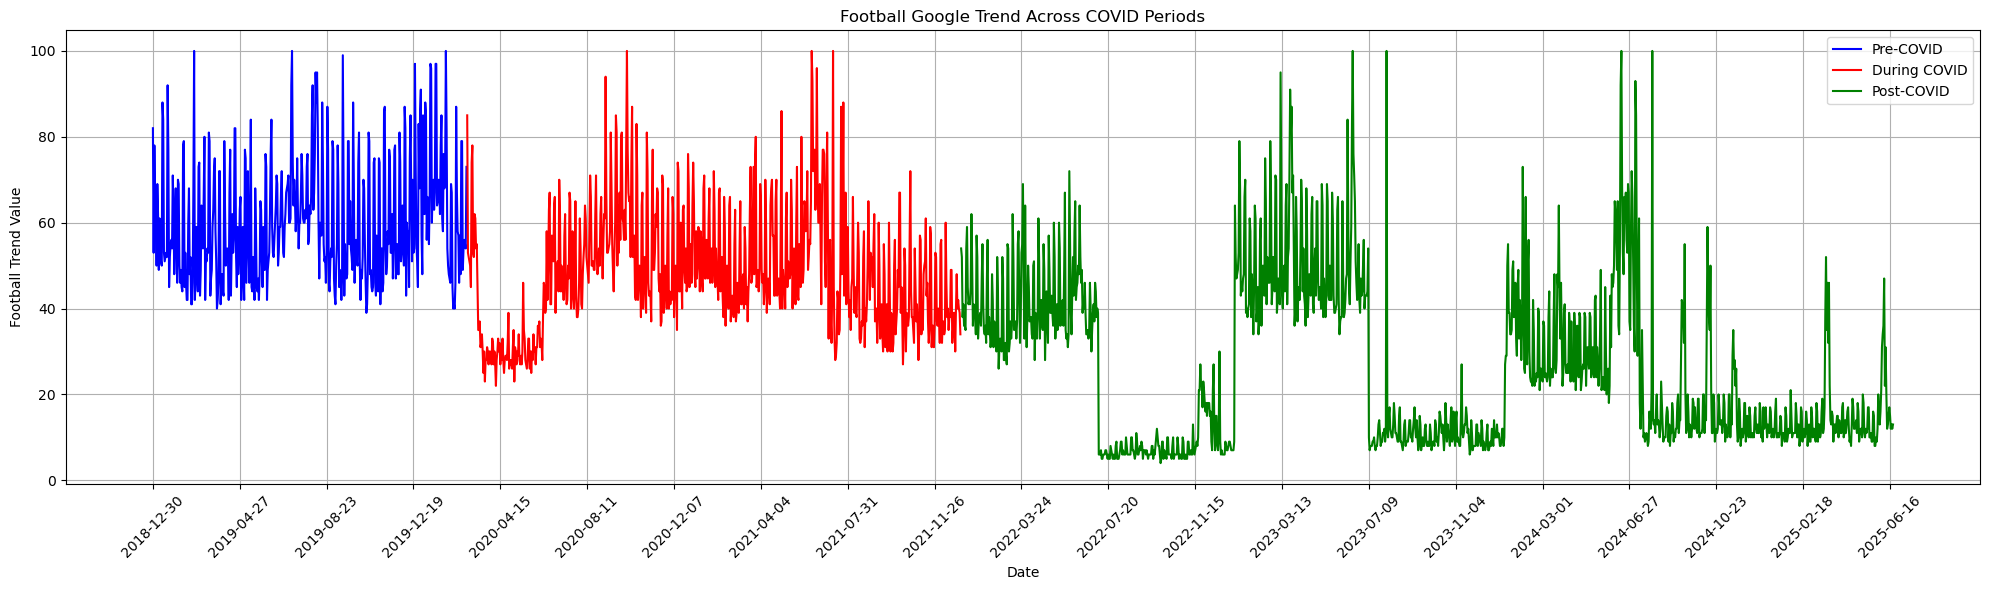

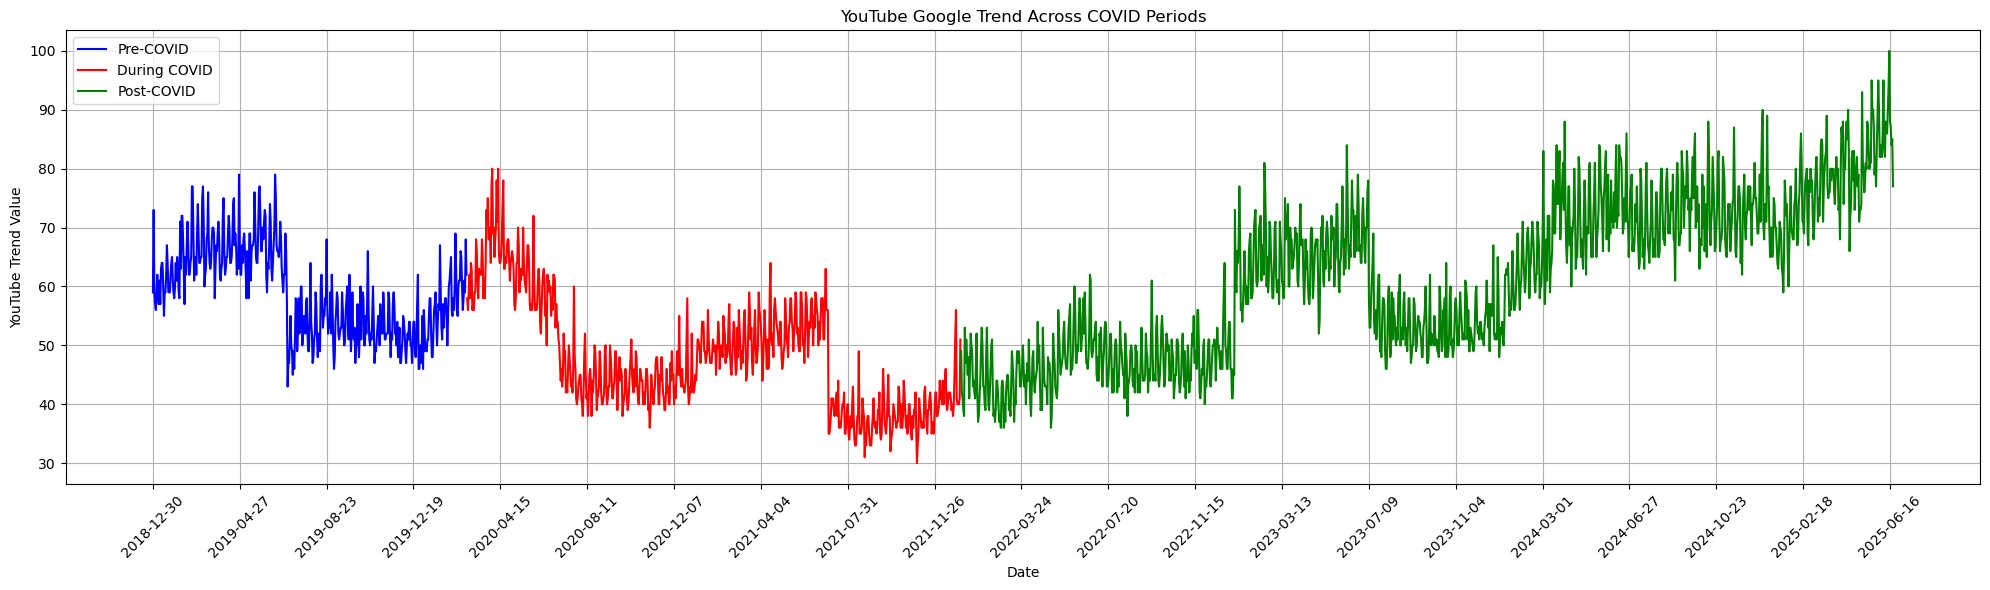

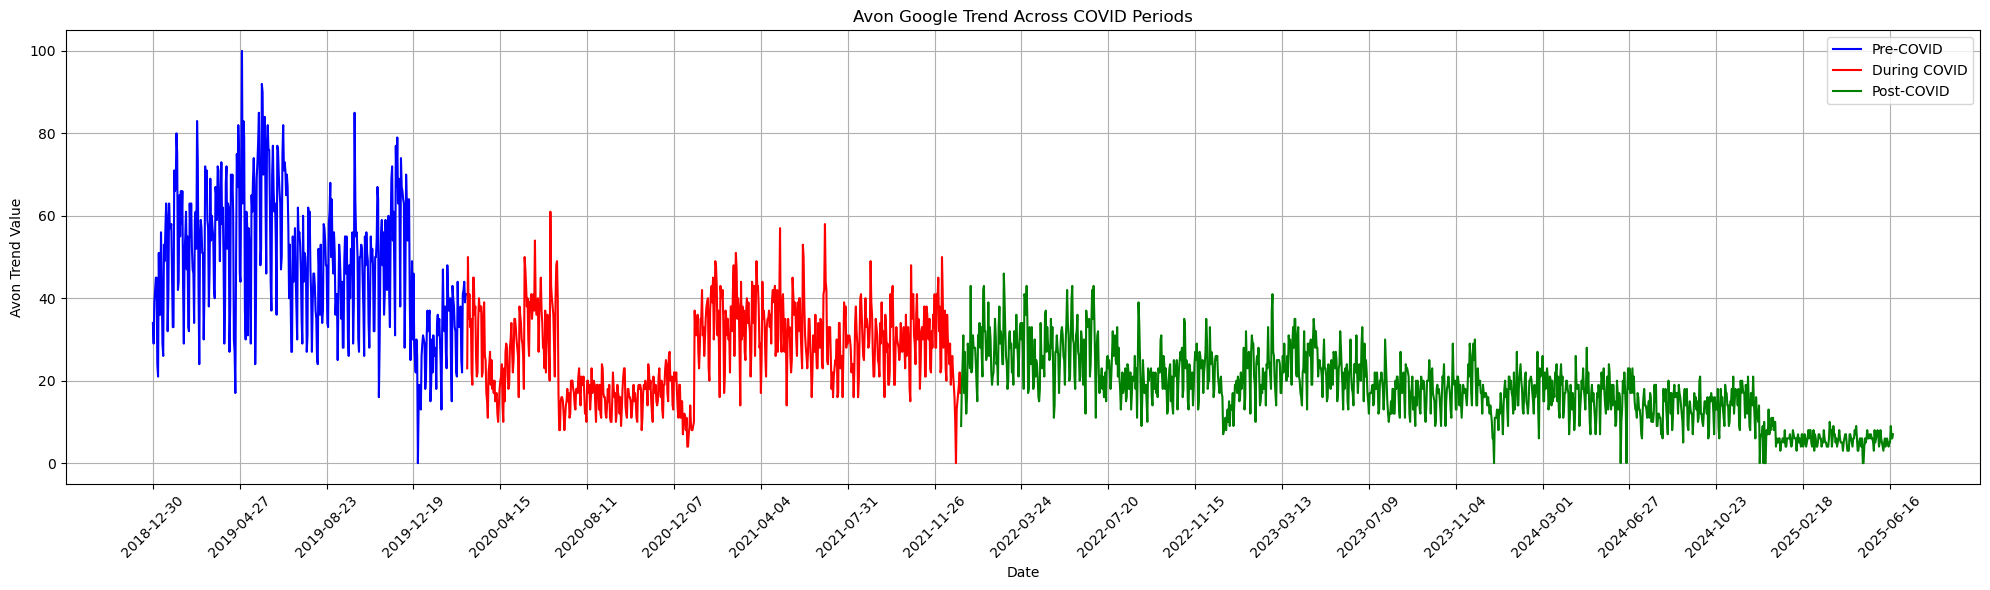

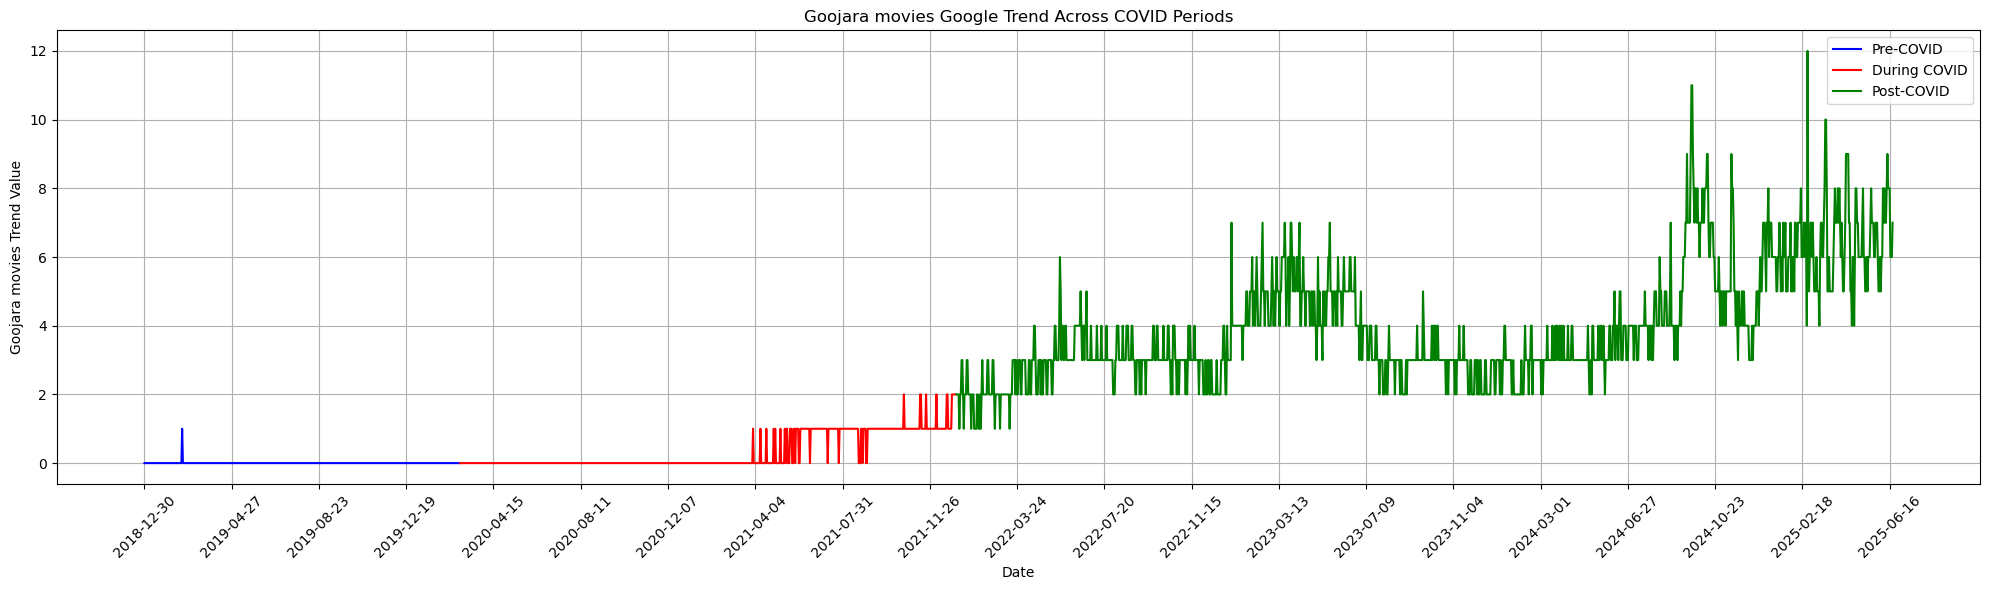

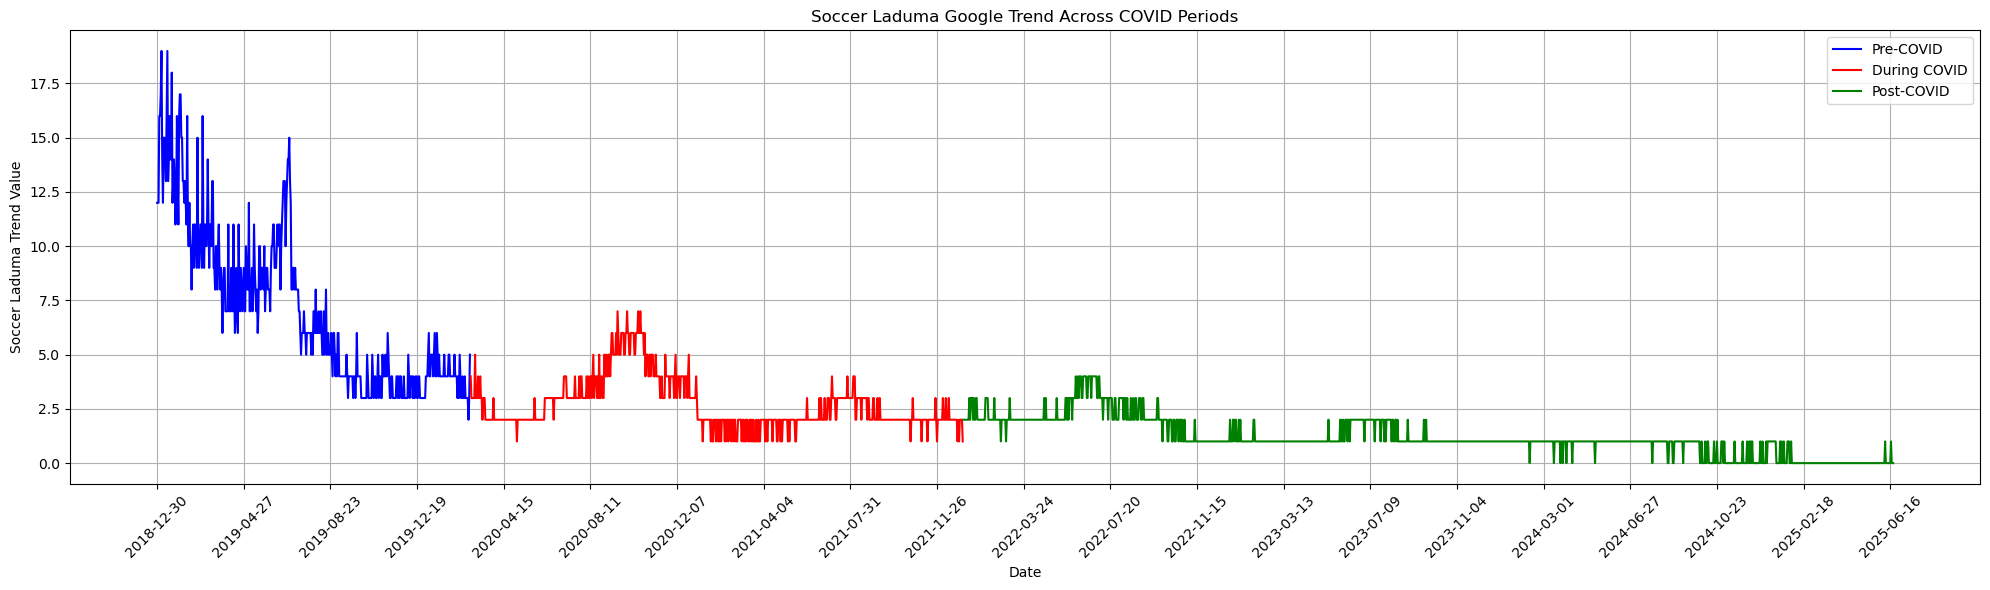

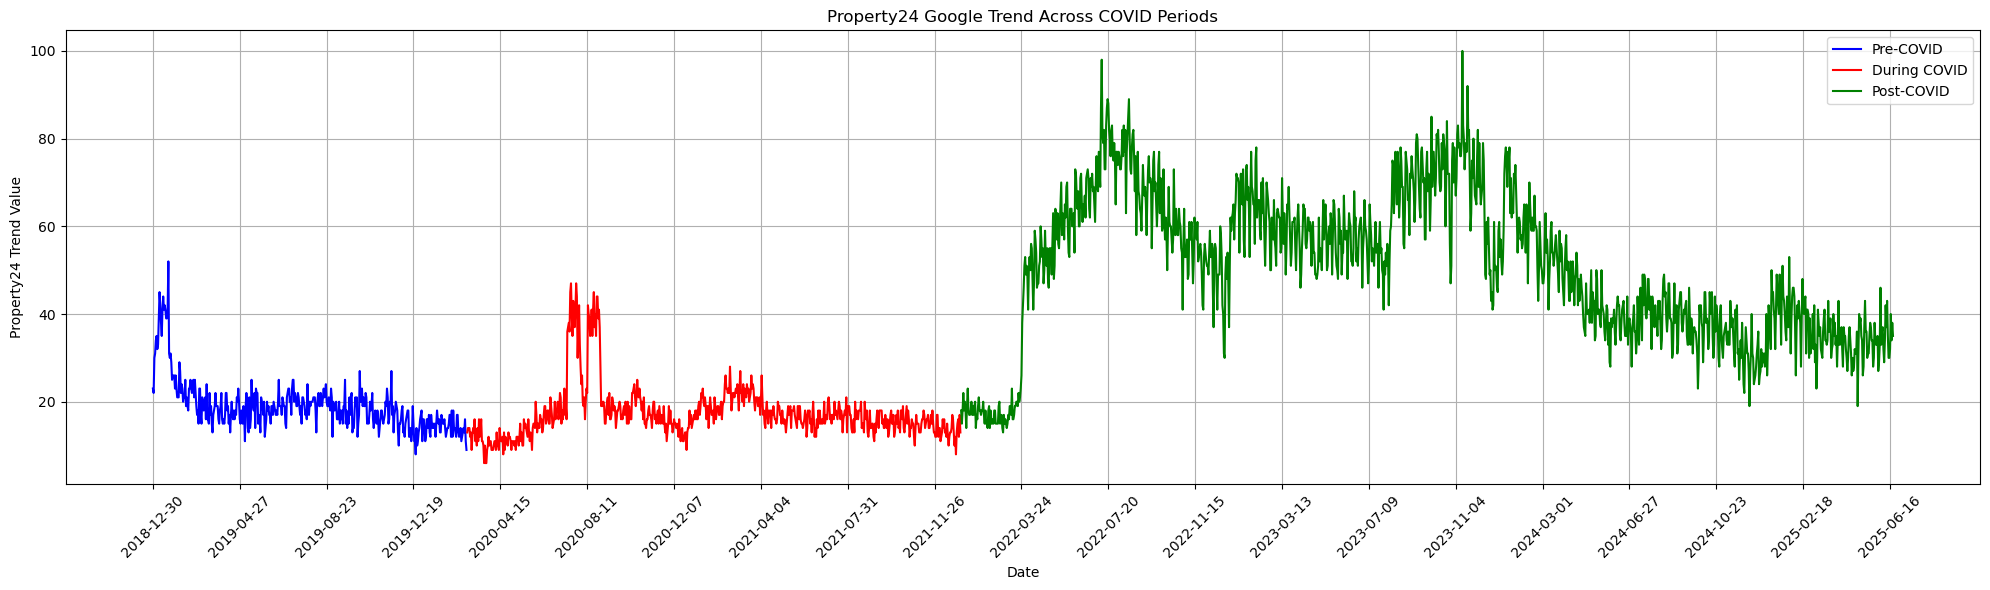

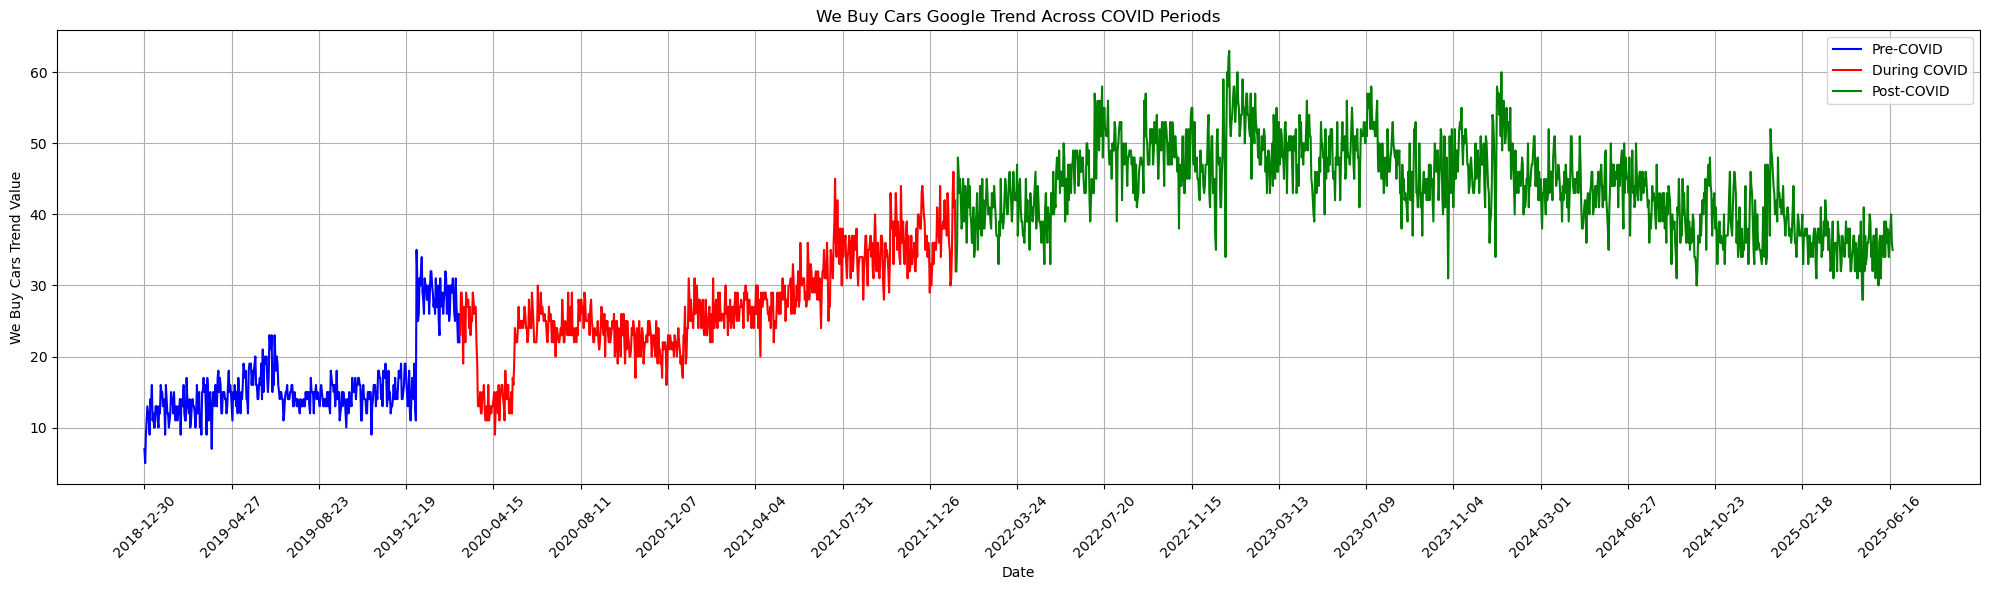

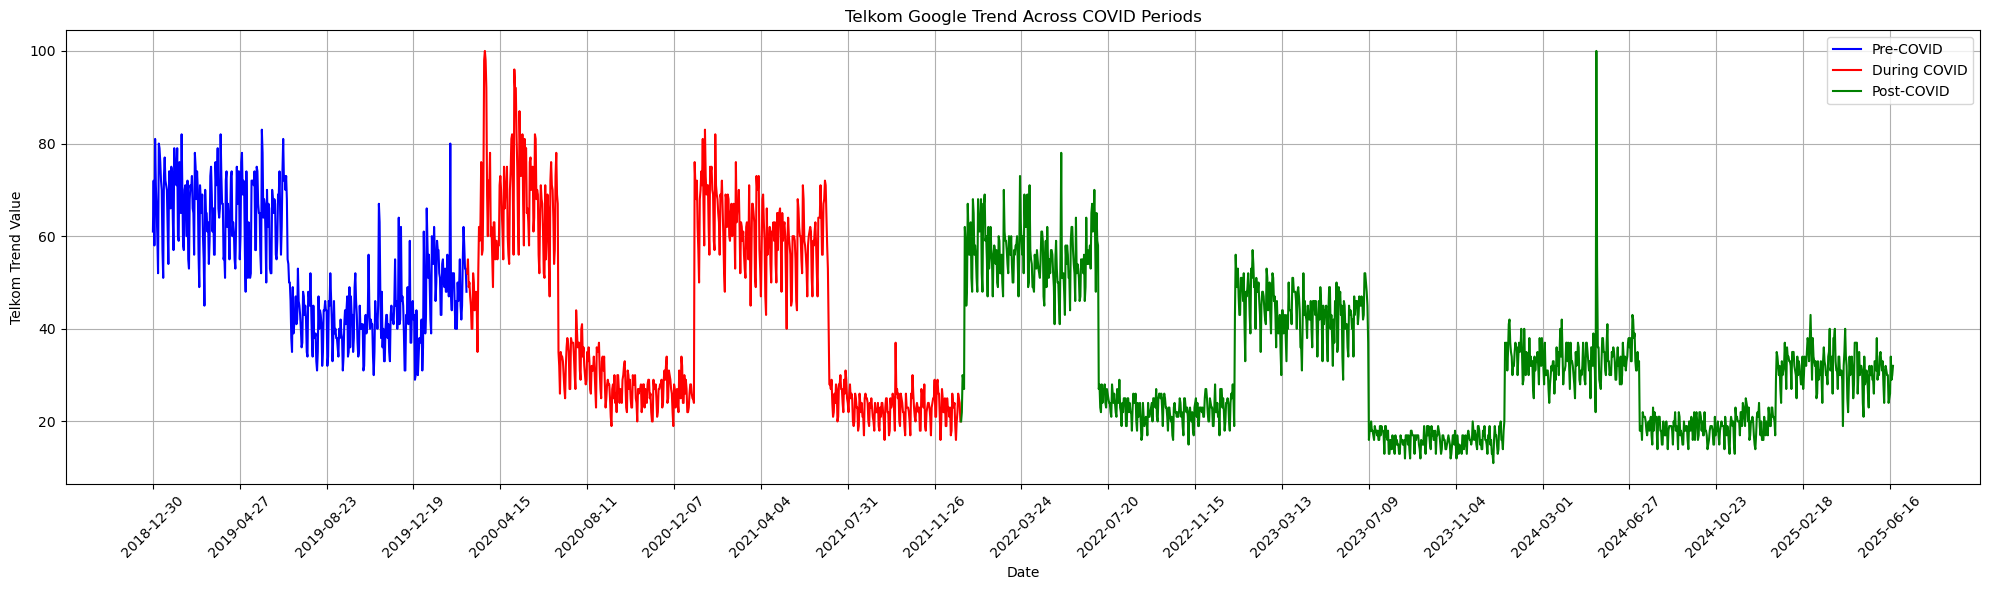

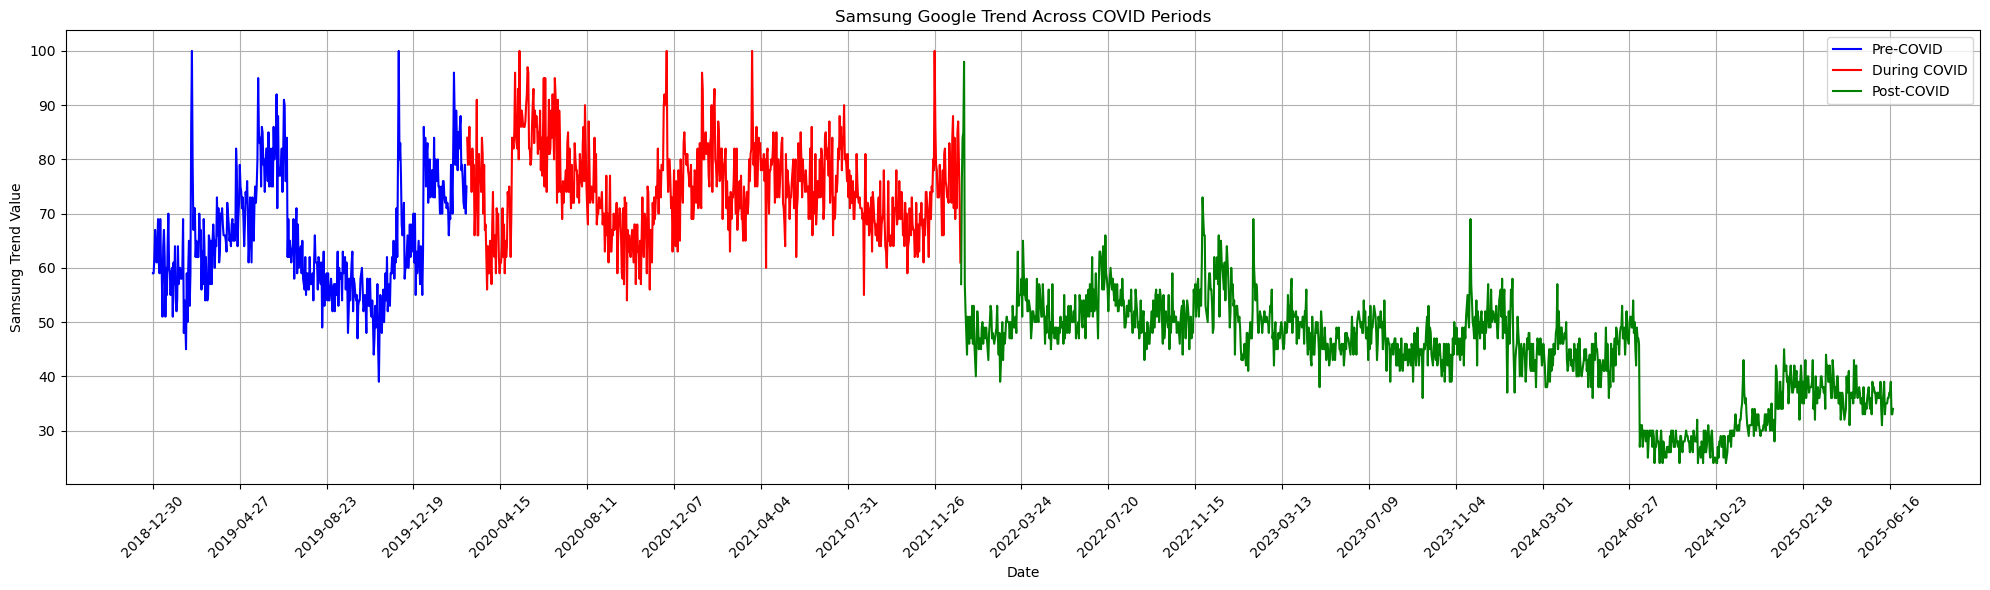

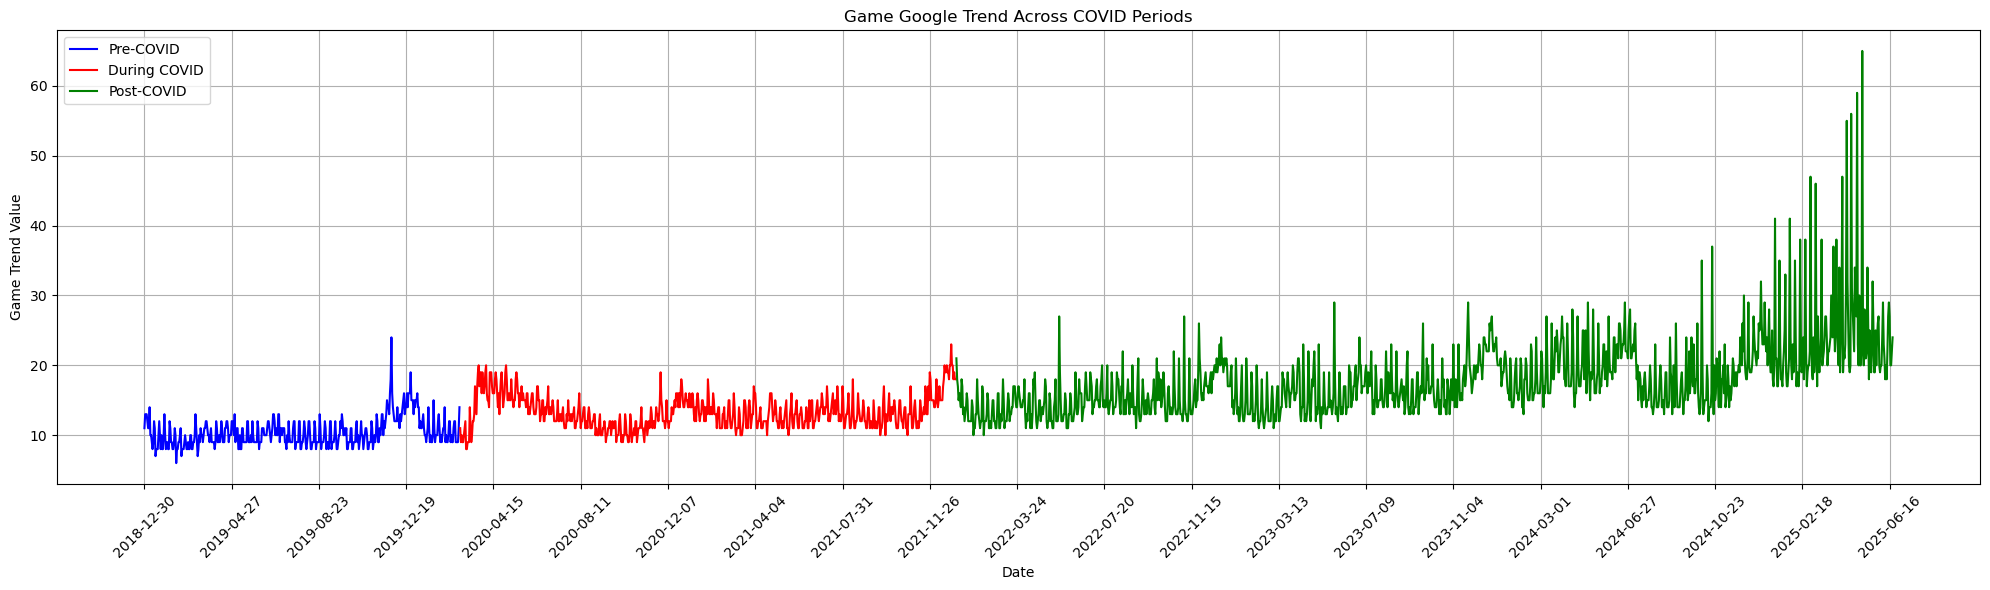

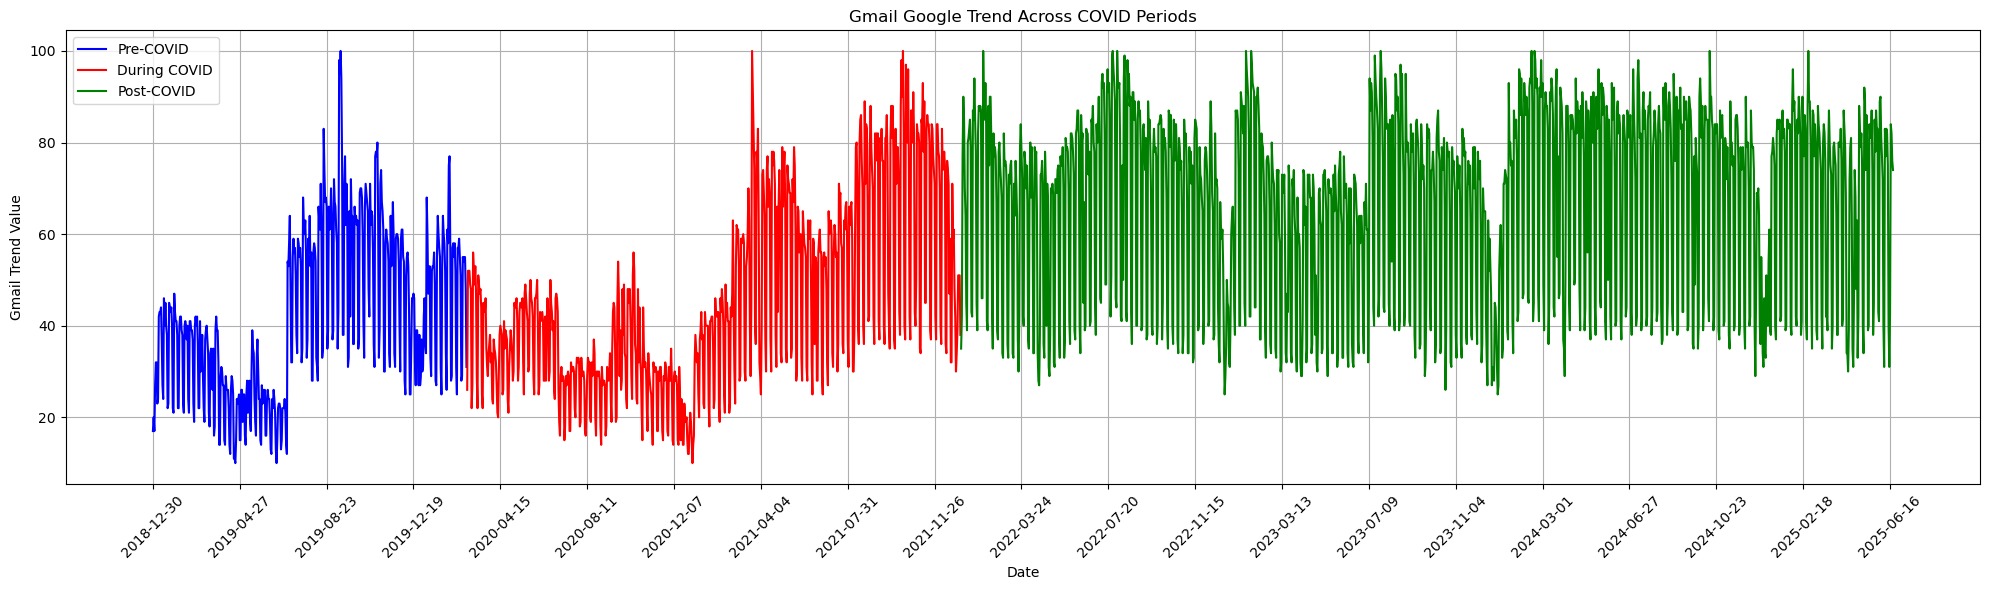

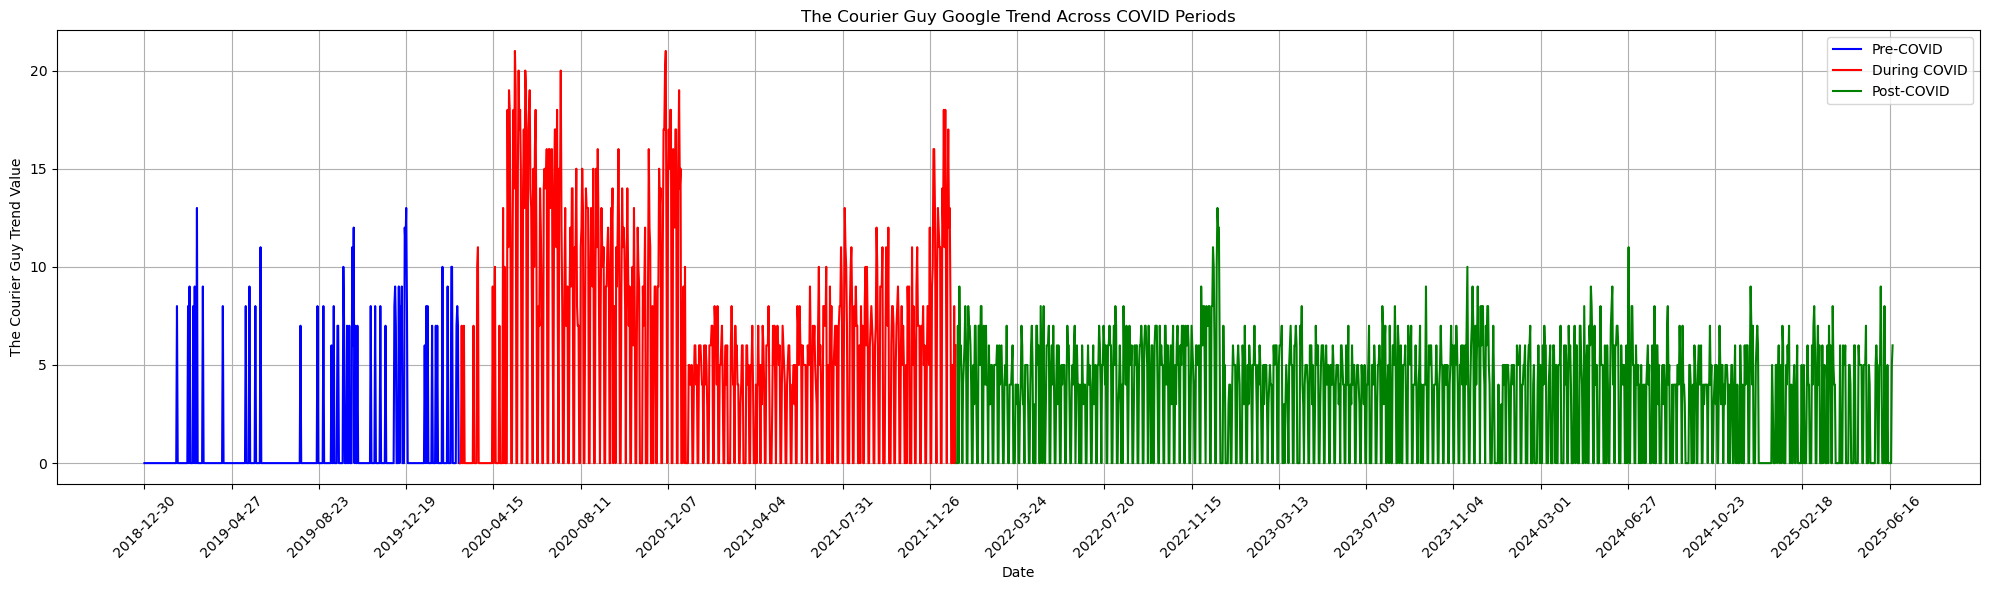

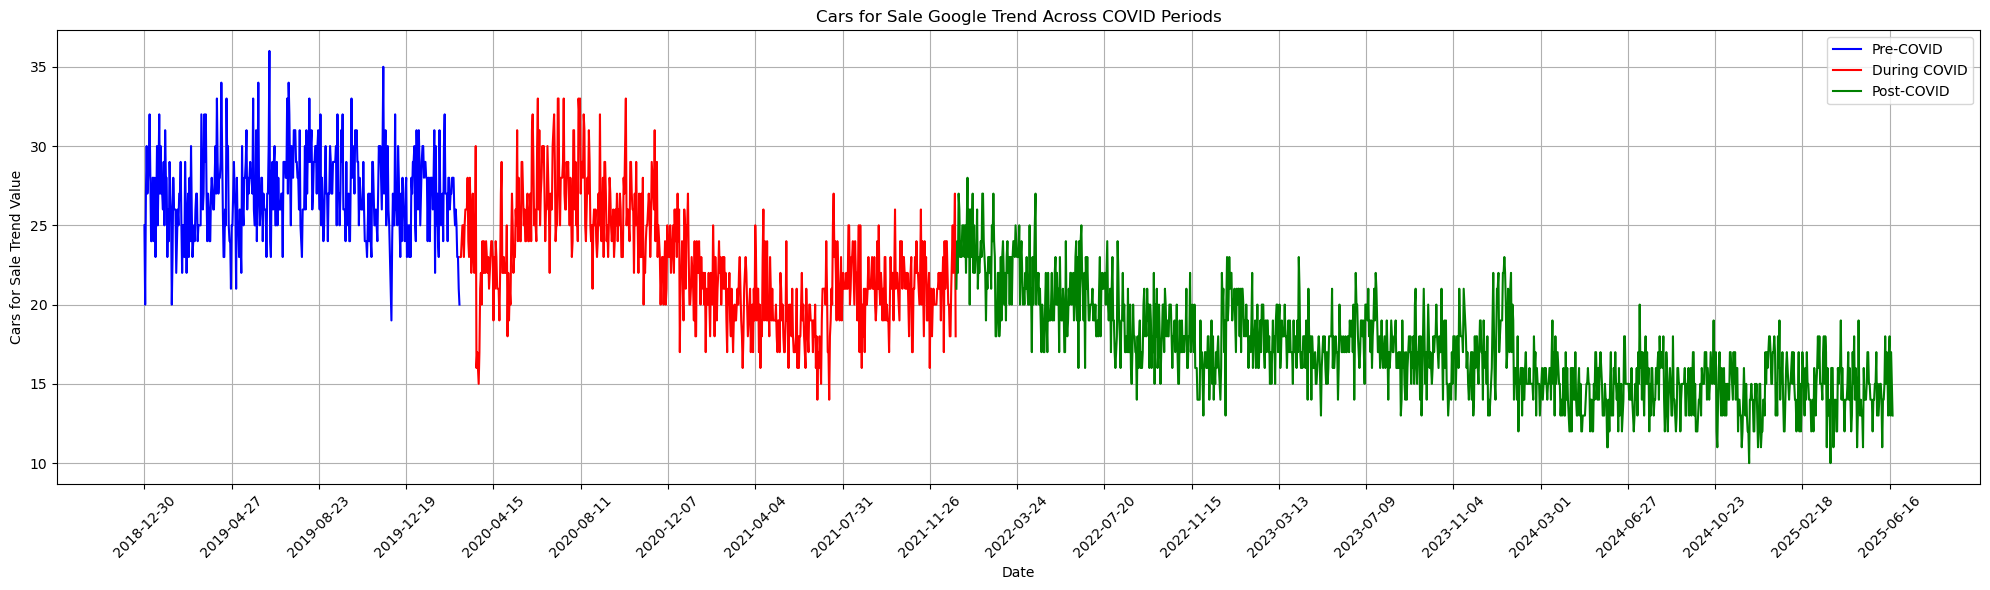

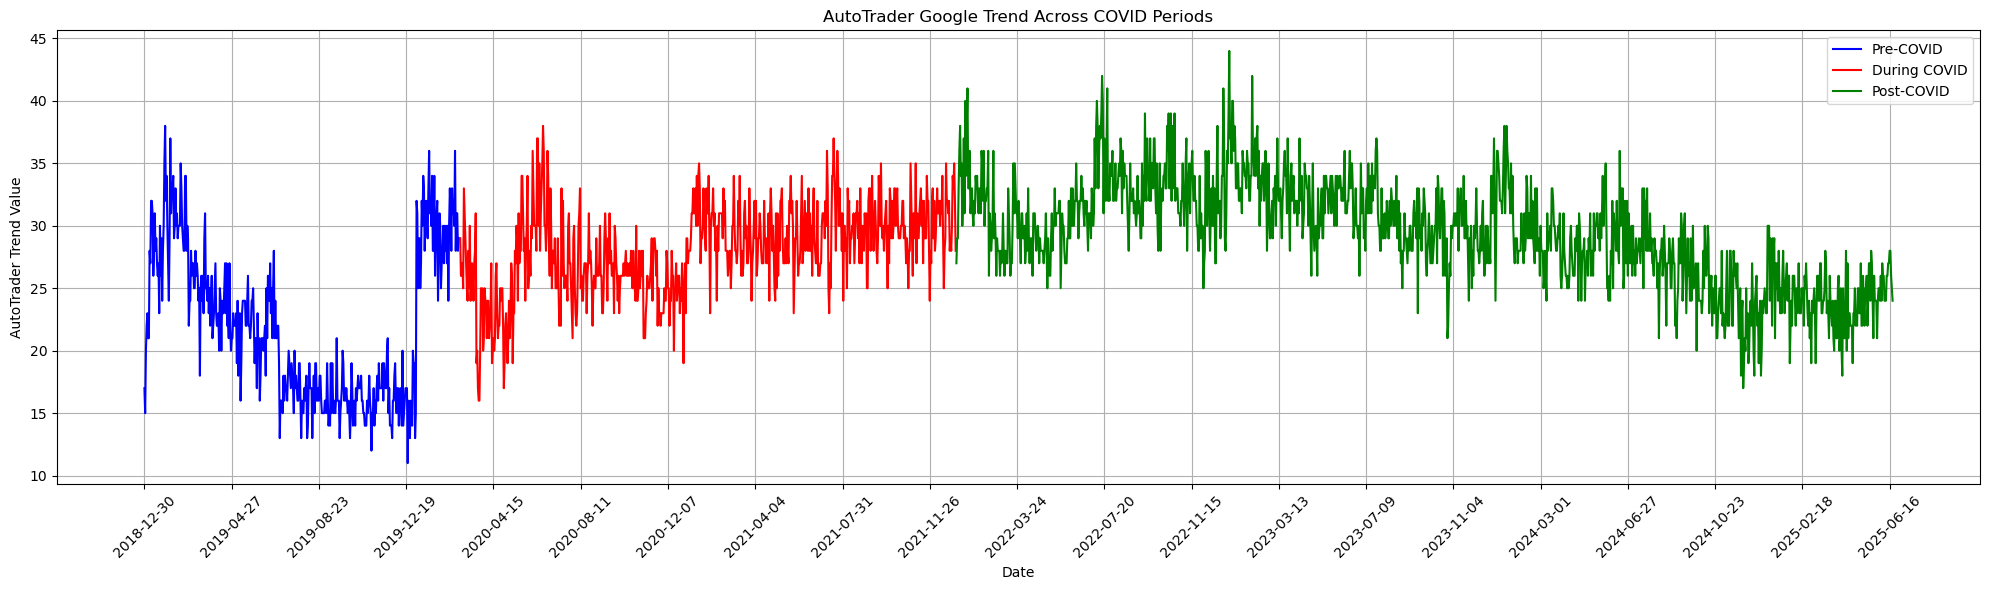

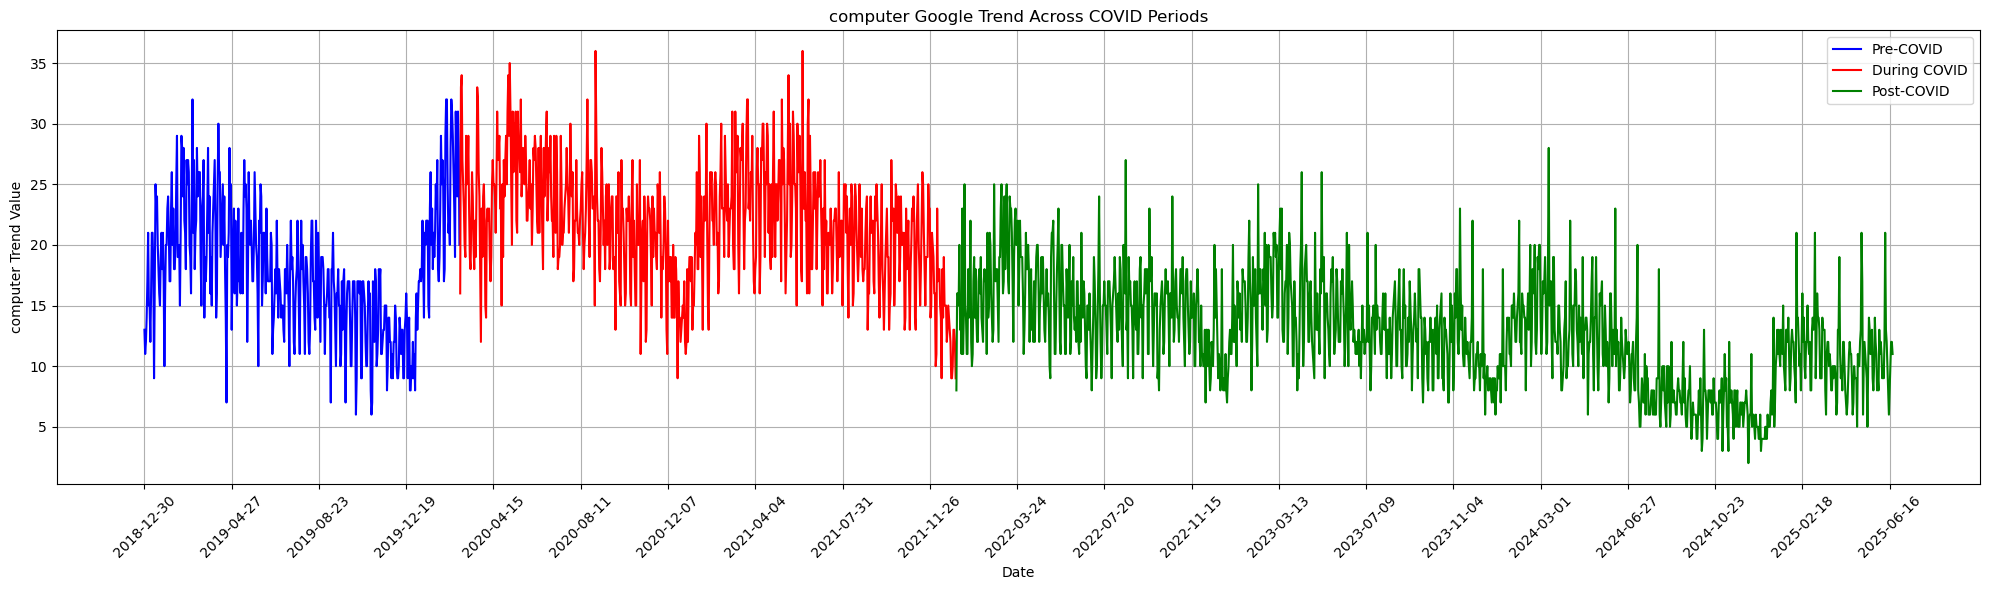

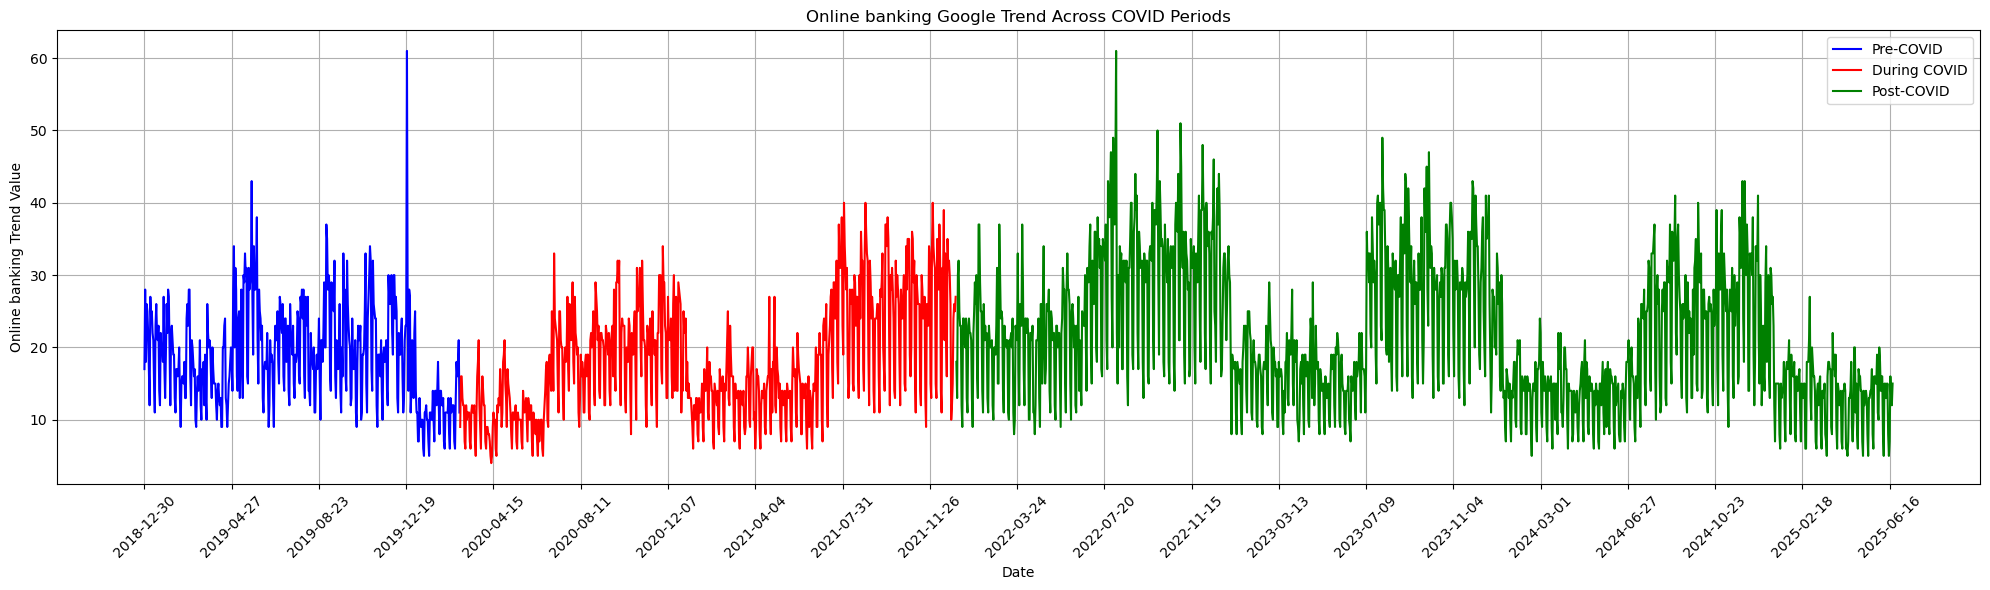

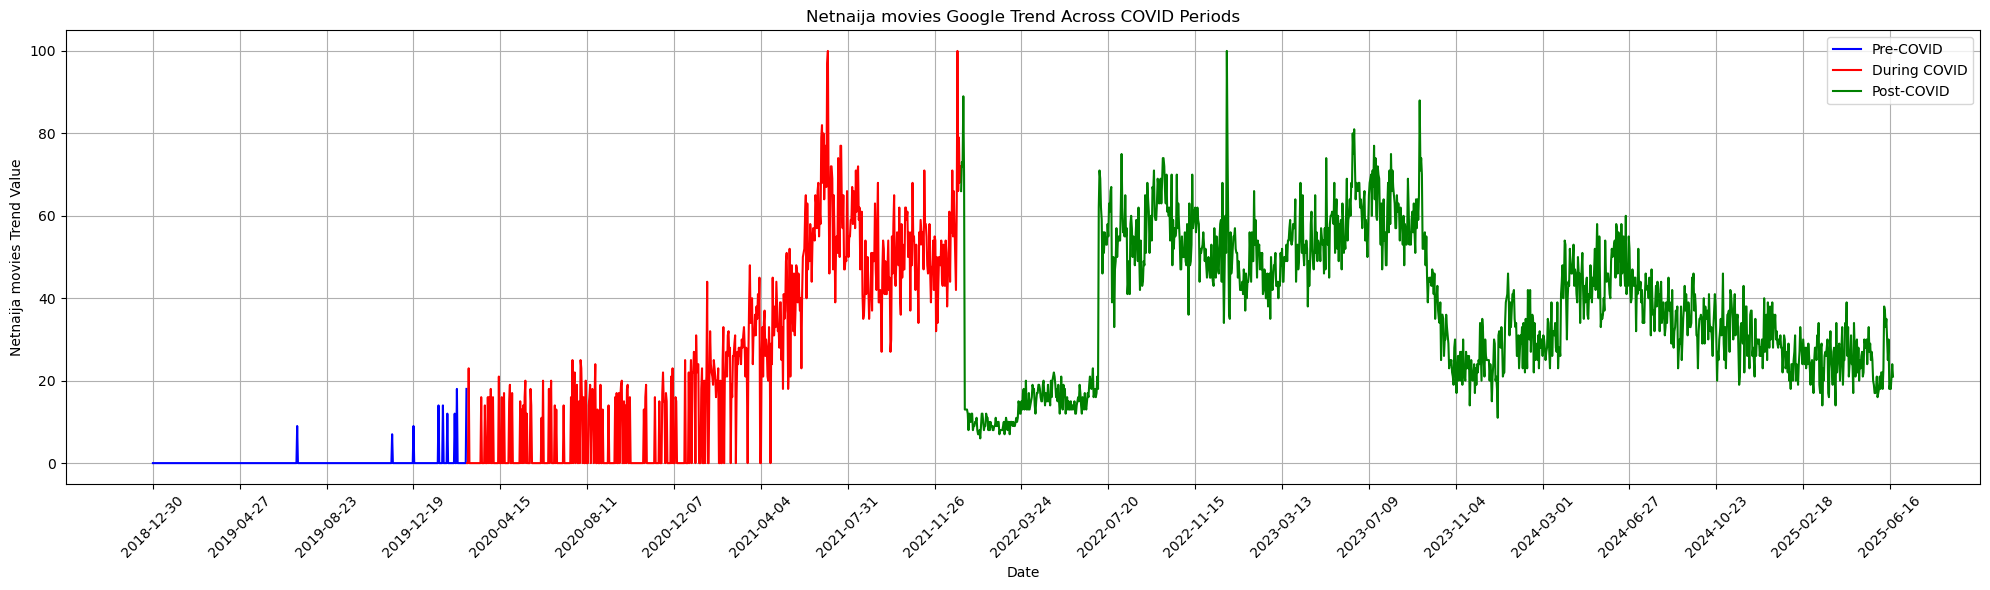

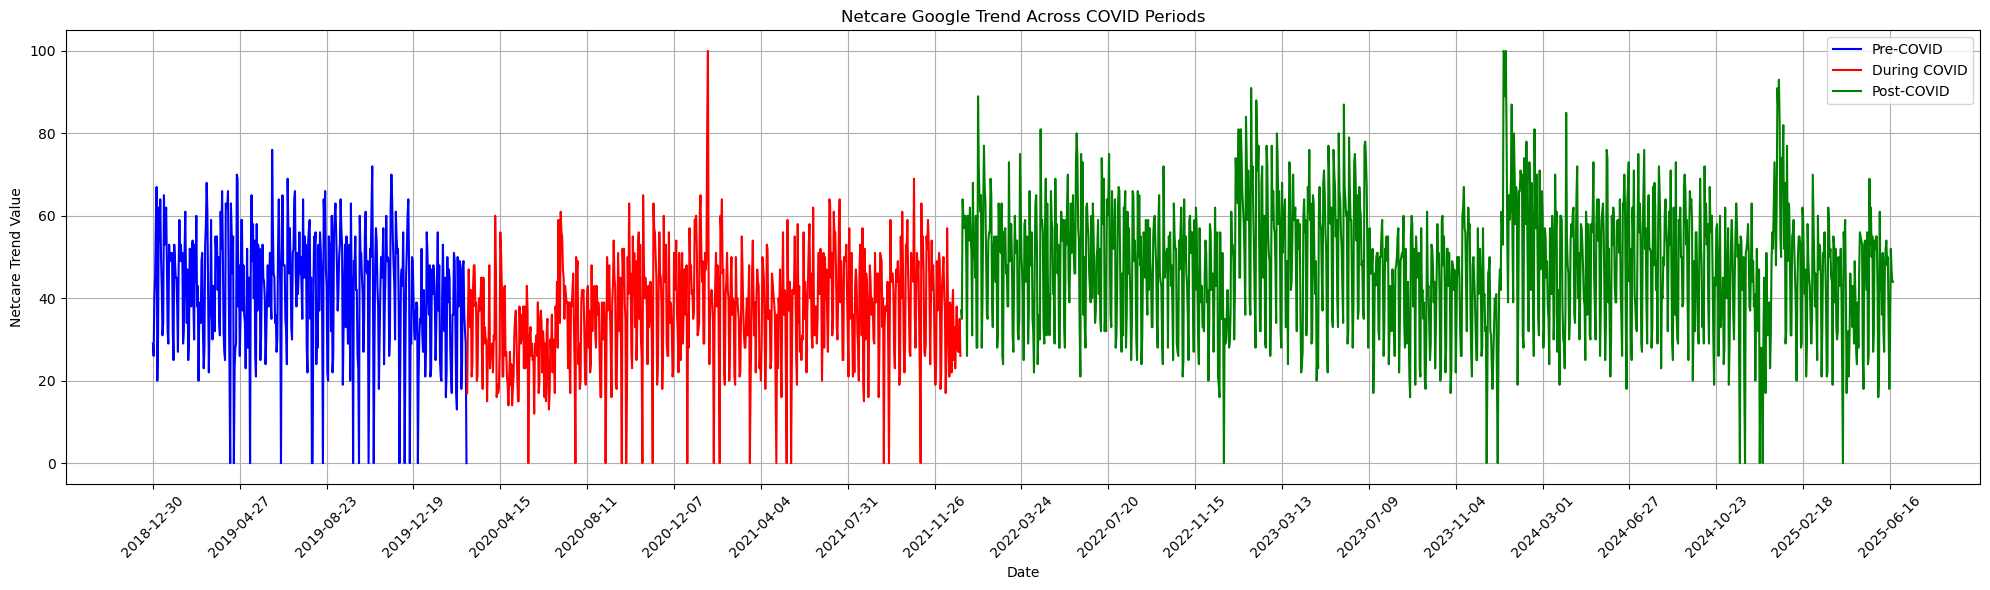

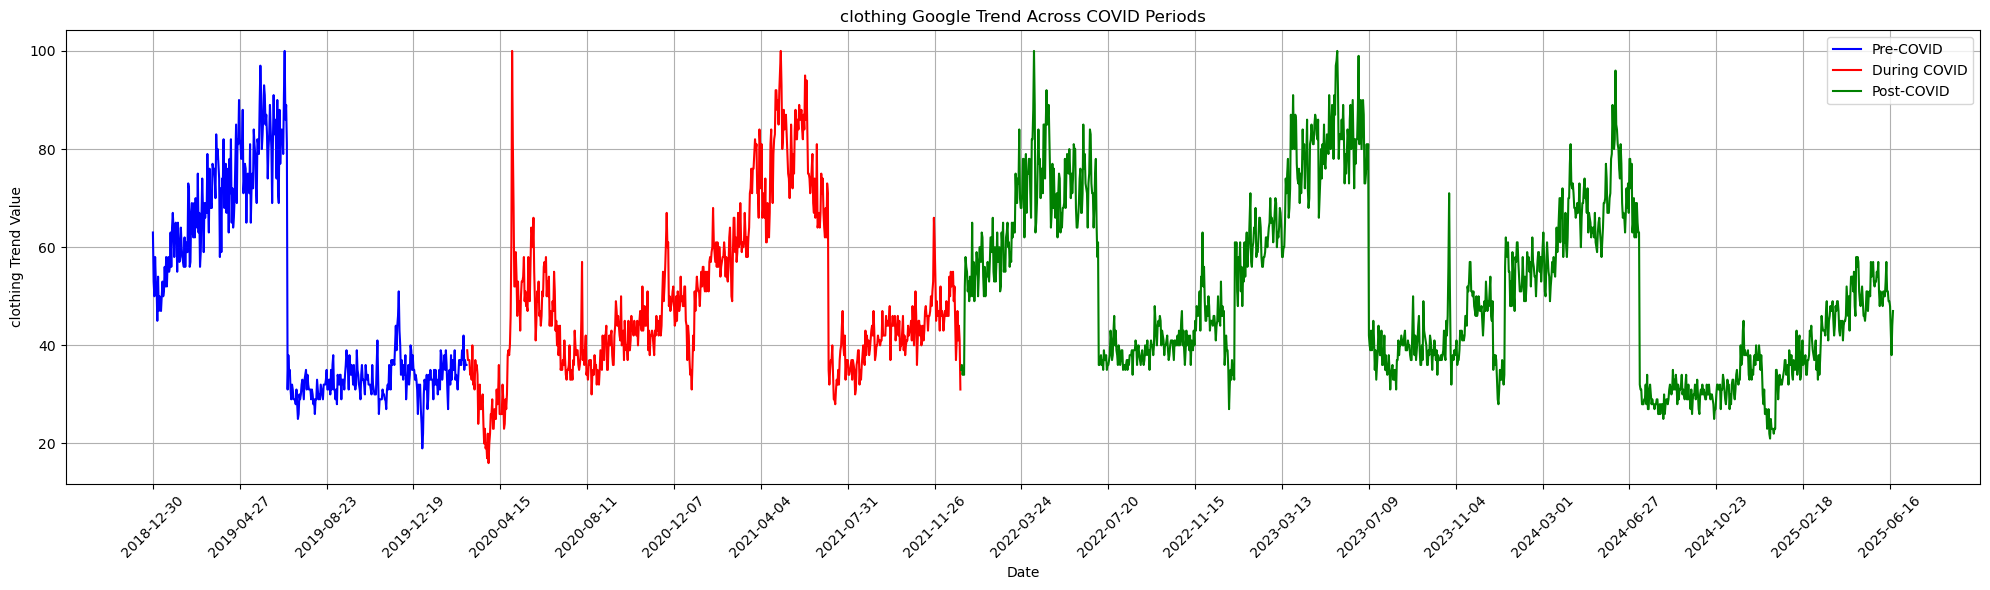

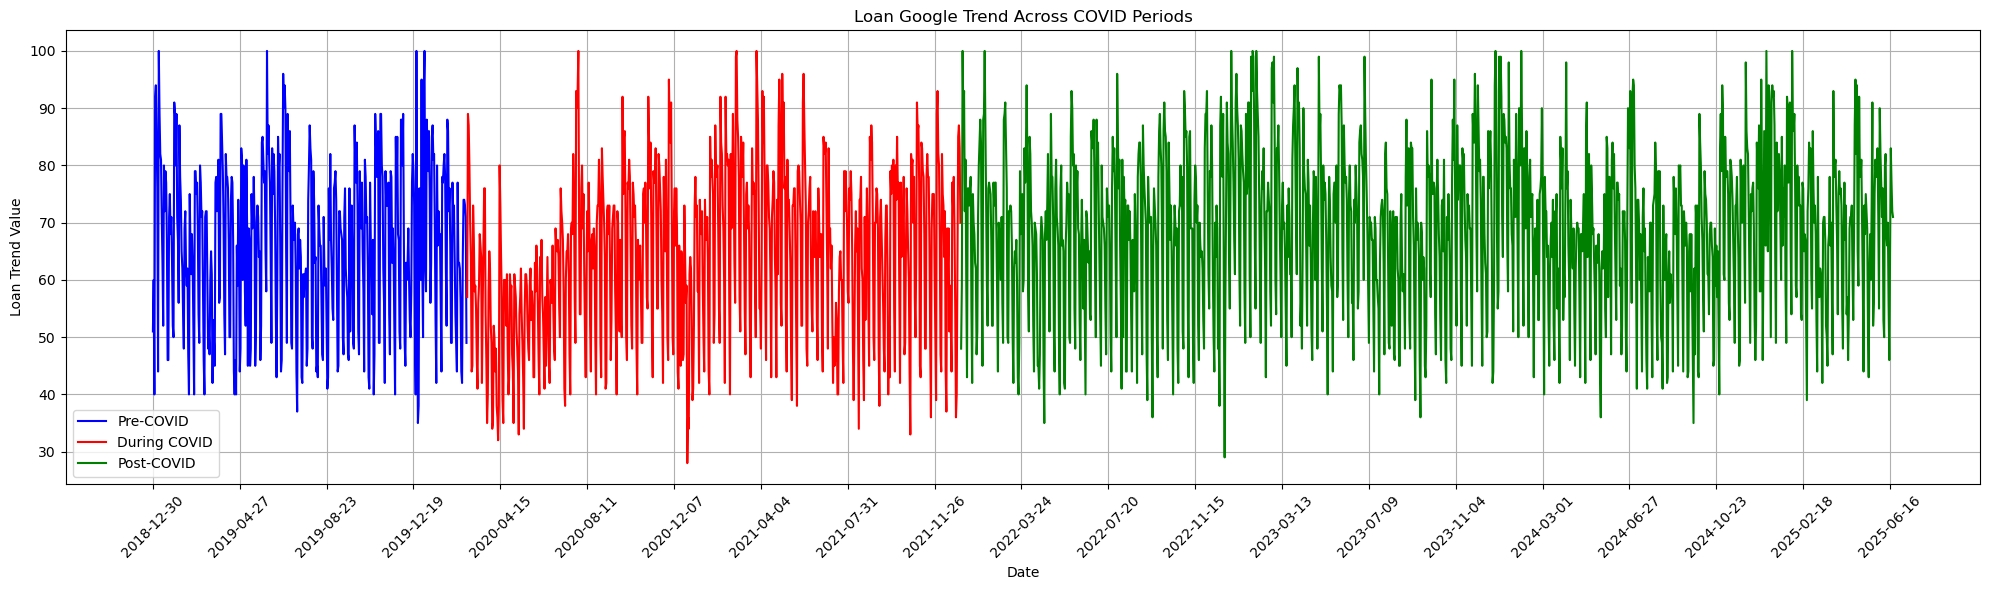

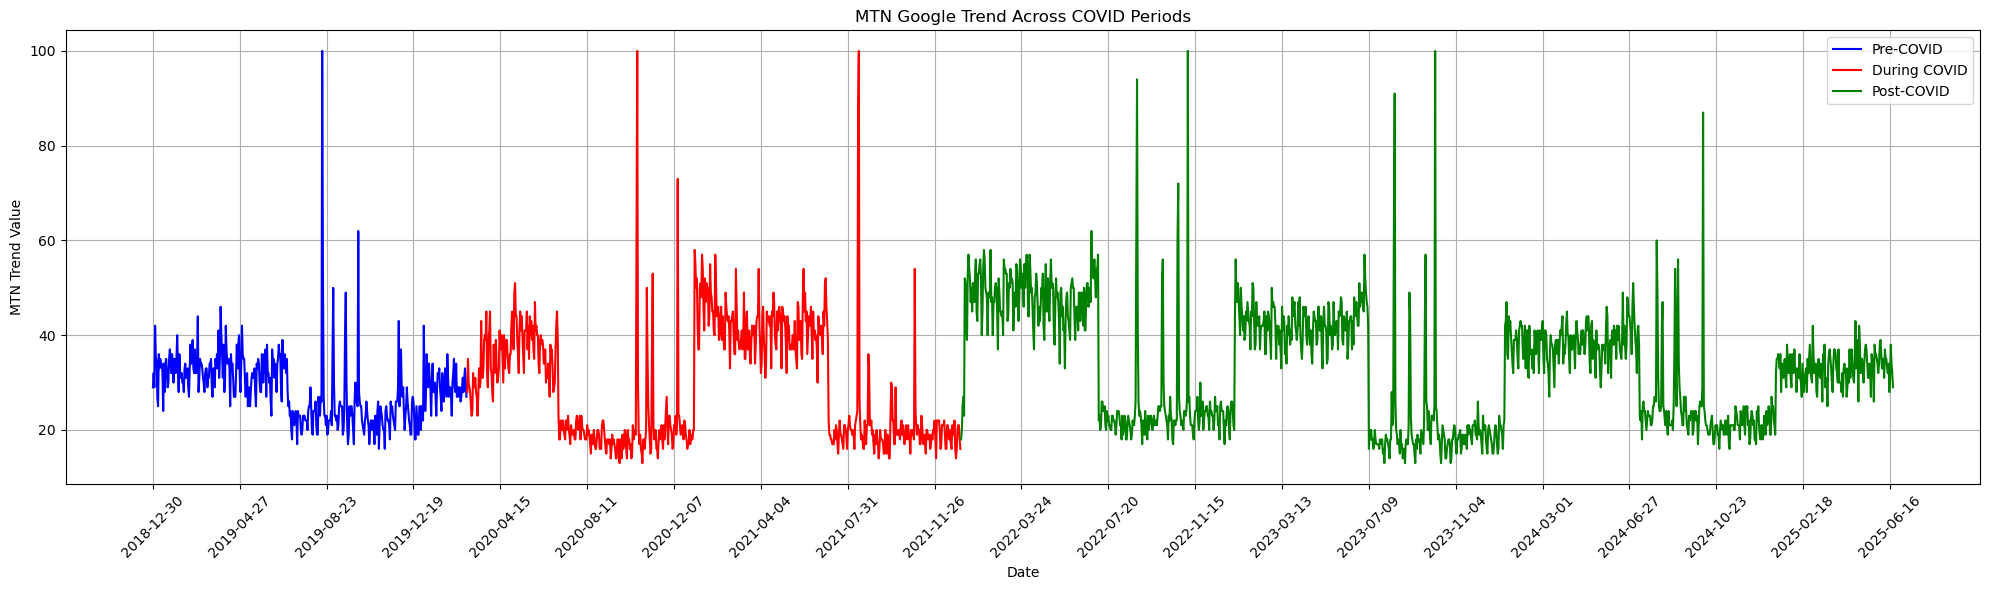

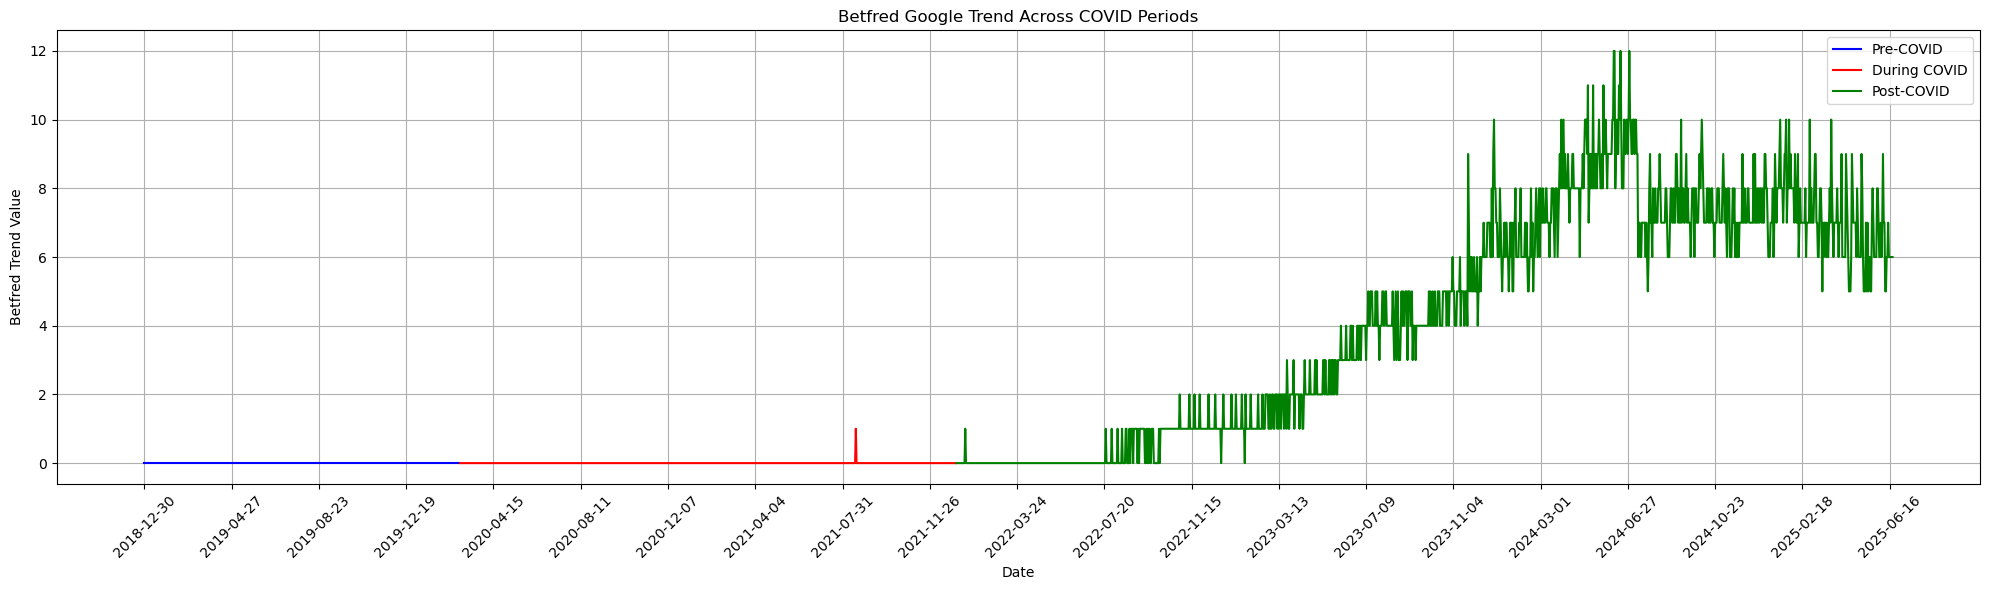

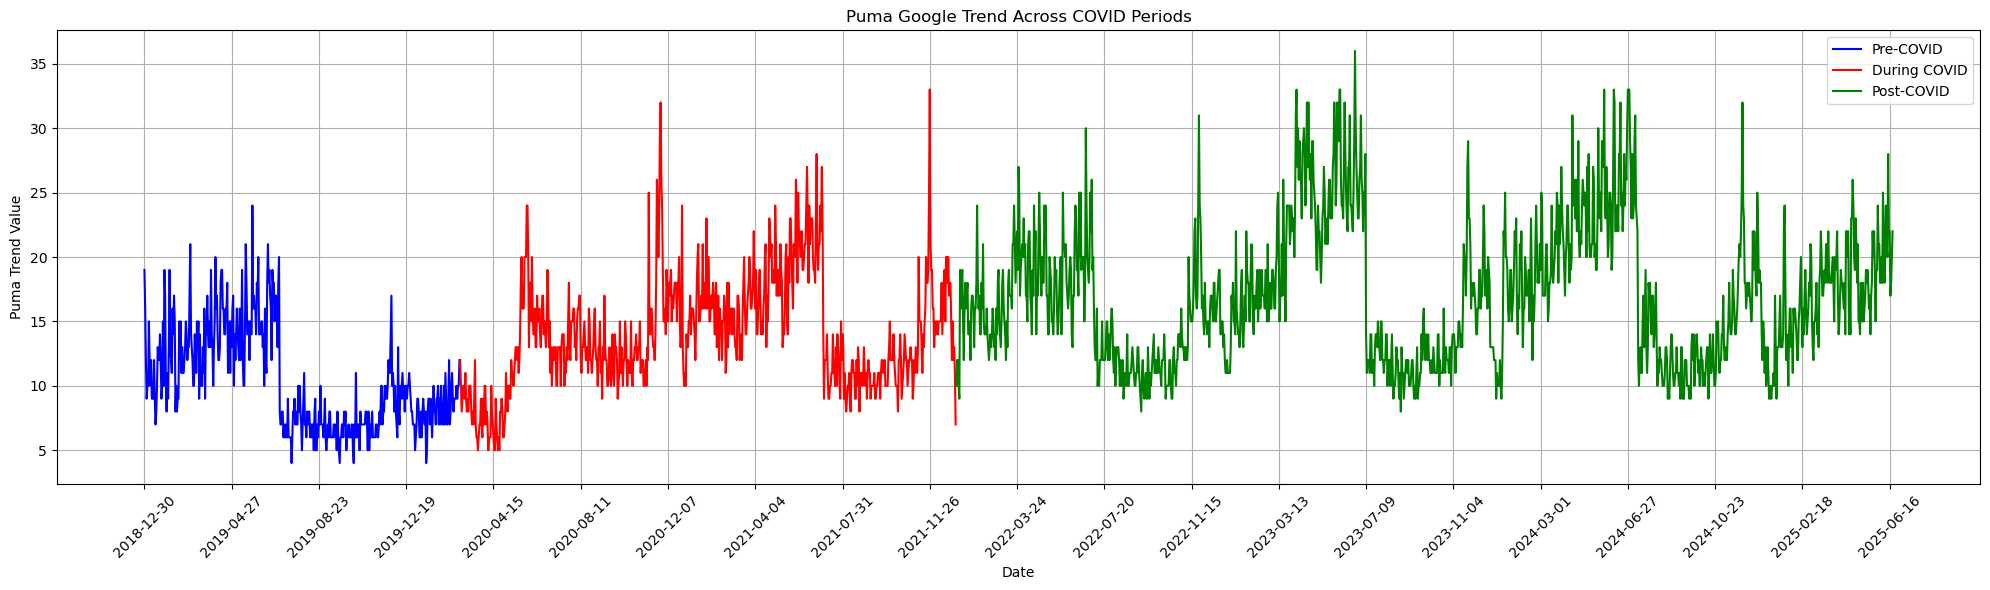

In [358]:
# List of Google Trends features
features = data.select_dtypes(include=np.number).columns.tolist()
# Define periods
pre_covid_end = '2020-02-29'
covid_start = '2020-03-01'
covid_end = '2021-12-31'
post_covid_start = '2022-01-01'

# Split data
data_pre_covid = data[data['date'] <= pre_covid_end]
data_covid = data[(data['date'] >= covid_start) & (data['date'] <= covid_end)]
data_post_covid = data[data['date'] >= post_covid_start]

# Loop through features
for feature in features:
    plt.figure(figsize=(20,6))
    plt.plot(data_pre_covid['date'], data_pre_covid[feature], label='Pre-COVID', color='blue')
    plt.plot(data_covid['date'], data_covid[feature], label='During COVID', color='red')
    plt.plot(data_post_covid['date'], data_post_covid[feature], label='Post-COVID', color='green')
    
    plt.xlabel('Date')
    plt.ylabel(f'{feature} Trend Value')
    plt.title(f'{feature} Google Trend Across COVID Periods')
    plt.legend()
    
    # Show all dates from the data on x-axis
    plt.xticks(data['date'][::max(1, len(data)//20)], rotation=45)  
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [359]:
# Parameters
window = 30      # size of rolling window
threshold = 3    # z-score threshold

# Select numeric features
features = data.select_dtypes(include=np.number).columns.tolist()

# Dictionary to store outlier indices per feature
outlier_indices = {}
total_outliers = 0

for feature in features:
    series = data[feature]
    
    # Rolling mean & std
    rolling_mean = series.rolling(window=window, center=True, min_periods=1).mean()
    rolling_std = series.rolling(window=window, center=True, min_periods=1).std()
    
    # Rolling z-score
    rolling_z = (series - rolling_mean) / rolling_std
    
    # Outlier indices
    outliers = np.where(np.abs(rolling_z) > threshold)[0]
    
    # Store and print
    outlier_indices[feature] = outliers
    total_outliers += len(outliers)
    print(f"{feature}: {len(outliers)}  outliers")

print(f"\nTotal rolling z-score outliers across all features: {total_outliers}")


Football: 8  outliers
YouTube: 3  outliers
Avon: 2  outliers
Goojara movies: 10  outliers
Soccer Laduma: 22  outliers
Property24: 0  outliers
We Buy Cars: 1  outliers
Telkom: 5  outliers
Samsung: 9  outliers
Game: 11  outliers
Gmail: 0  outliers
The Courier Guy: 8  outliers
Cars for Sale: 1  outliers
AutoTrader: 3  outliers
computer: 18  outliers
Online banking: 1  outliers
Netnaija movies: 12  outliers
Netcare: 2  outliers
clothing: 7  outliers
Loan: 0  outliers
MTN: 22  outliers
Betfred: 7  outliers
Puma: 8  outliers

Total rolling z-score outliers across all features: 160


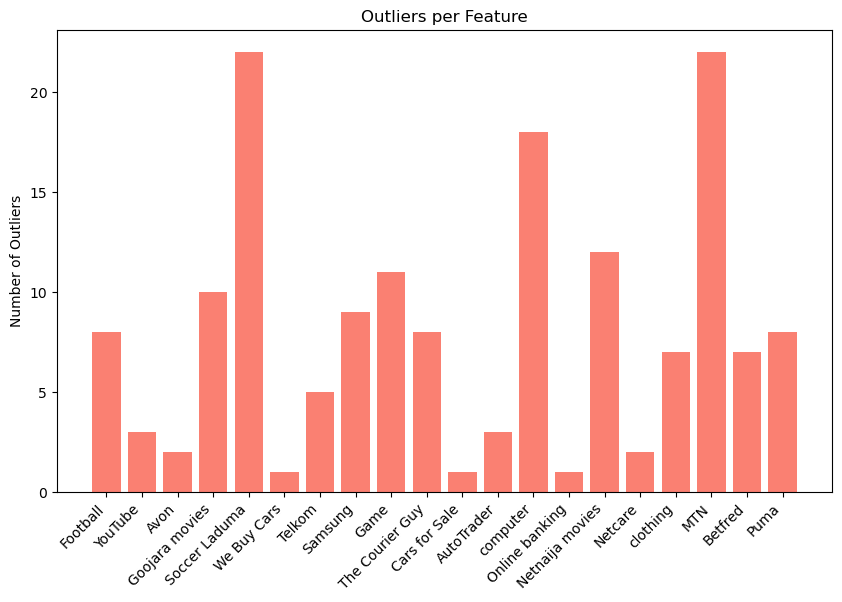

In [360]:
# Count of outliers per feature
outlier_counts = {feature: len(indices) for feature, indices in outlier_indices.items()}

# Filter only features with outliers
outlier_counts = {k: v for k, v in outlier_counts.items() if v > 0}

# Plot
plt.figure(figsize=(10, 6))
plt.bar(outlier_counts.keys(), outlier_counts.values(), color='salmon')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Outliers')
plt.title('Outliers per Feature')
plt.show()

In [361]:
print(f"Total outliers across all features: {total_outliers}")

Total outliers across all features: 160


In [362]:
# Make a copy of the original data
data_cleaned = data.copy()

# Replace outliers with rolling mean
for feature in features:
    series = data_cleaned[feature]
    
    # Get indices of outliers for this feature
    outliers = outlier_indices[feature]
    
    # Use the already computed rolling mean
    rolling_mean_feature = series.rolling(window=window, center=True, min_periods=1).median()
    
    # Replace outliers with rolling mean
    series.iloc[outliers] = rolling_mean_feature.iloc[outliers]
    
    data_cleaned[feature] = series

print(" Data shape remains:", data_cleaned.shape)

 Data shape remains: (2365, 24)


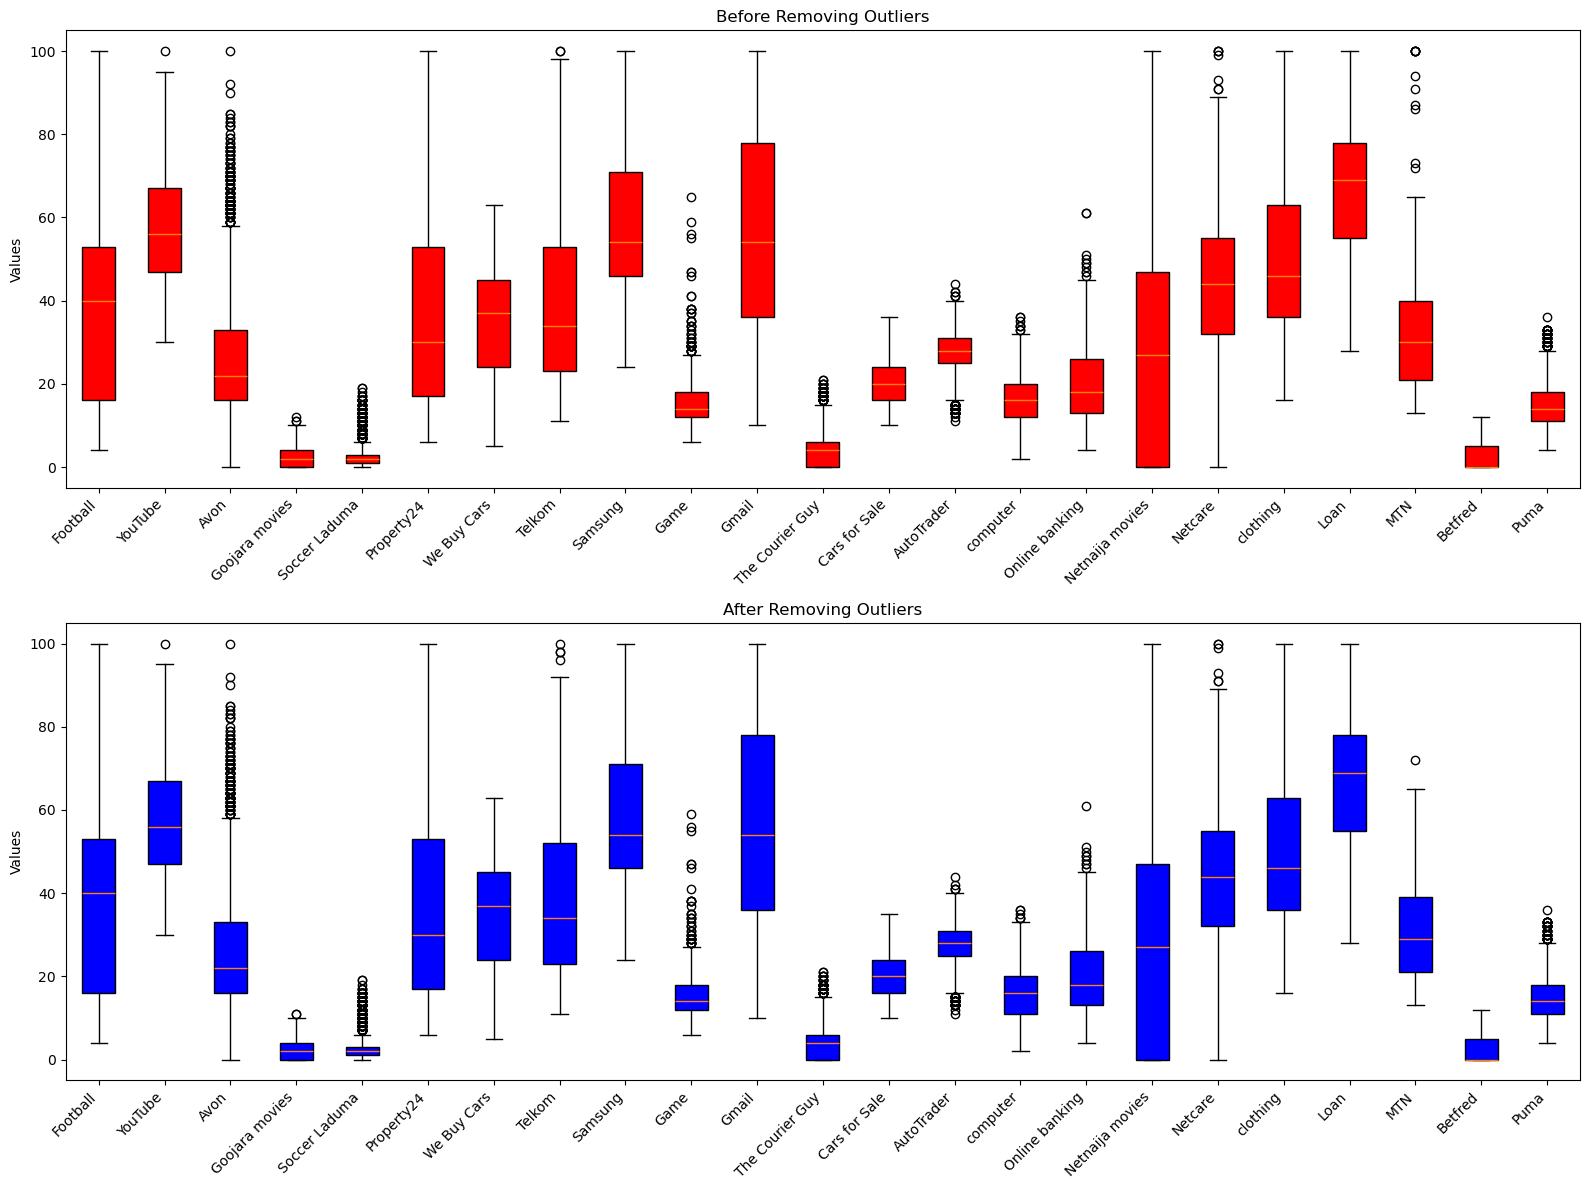

In [363]:
plt.figure(figsize=(16, 12))  

# Boxplot before removing outliers 
plt.subplot(2, 1, 1)
box_before = plt.boxplot([data[feat] for feat in features],
                         labels=features,
                         patch_artist=True)
for patch in box_before['boxes']:
    patch.set_facecolor('red')  
plt.title('Before Removing Outliers')
plt.ylabel('Values')
plt.xticks(rotation=45, ha='right')

# Boxplot after removing outliers 
plt.subplot(2, 1, 2)
box_after = plt.boxplot([data_cleaned[feat] for feat in features],
                        labels=features,
                        patch_artist=True)
for patch in box_after['boxes']:
    patch.set_facecolor('blue') 
plt.title('After Removing Outliers')
plt.ylabel('Values')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [364]:
data_cleaned.head()

date  Football  YouTube  Avon  Goojara movies  Soccer Laduma  \
0  2018-12-30      82.0     59.0    34               0             12   
1  2018-12-31      53.0     73.0    29               0             12   
2  2019-01-01      78.0     59.0    39               0             12   
3  2019-01-02      64.0     57.0    42               0             16   
4  2019-01-03      64.0     56.0    45               0             16   

   Property24  We Buy Cars  Telkom  Samsung  ...  AutoTrader  computer  \
0          23          7.0    61.0     59.0  ...        17.0      13.0   
1          22          5.0    72.0     59.0  ...        15.0      11.0   
2          30          9.0    58.0     62.0  ...        20.0      12.0   
3          31         11.0    81.0     67.0  ...        22.0      14.0   
4          34         13.0    71.0     64.0  ...        23.0      17.0   

   Online banking  Netnaija movies  Netcare  clothing  Loan   MTN  Betfred  \
0              17              0.0     29.0      63.0    51  29.0      0.0   
1              28              0.0     26.0      53.0    60  32.0      0.0   
2              18              0.0     40.0      50.0    40  29.0      0.0   
3              26              0.0     45.0      58.0    92  42.0      0.0   
4              25              0.0     58.0      53.0    94  35.0      0.0   

   Puma  
0  19.0  
1  16.0  
2  12.0  
3   9.0  
4  10.0  

[5 rows x 24 columns]

In [365]:
# Exclude 'date' column
numeric_features = data_cleaned.select_dtypes(include=['float64', 'int64']).columns

# Apply Savitzky-Golay filter to numeric features only
for feature in numeric_features:
    window_length = 31
    data_cleaned[feature] = savgol_filter(data_cleaned[feature], window_length=window_length, polyorder=2)


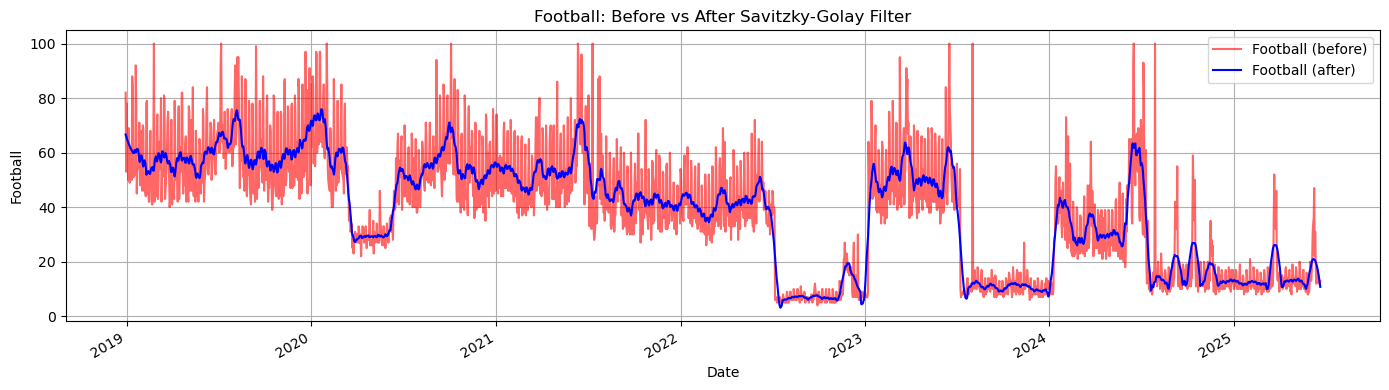

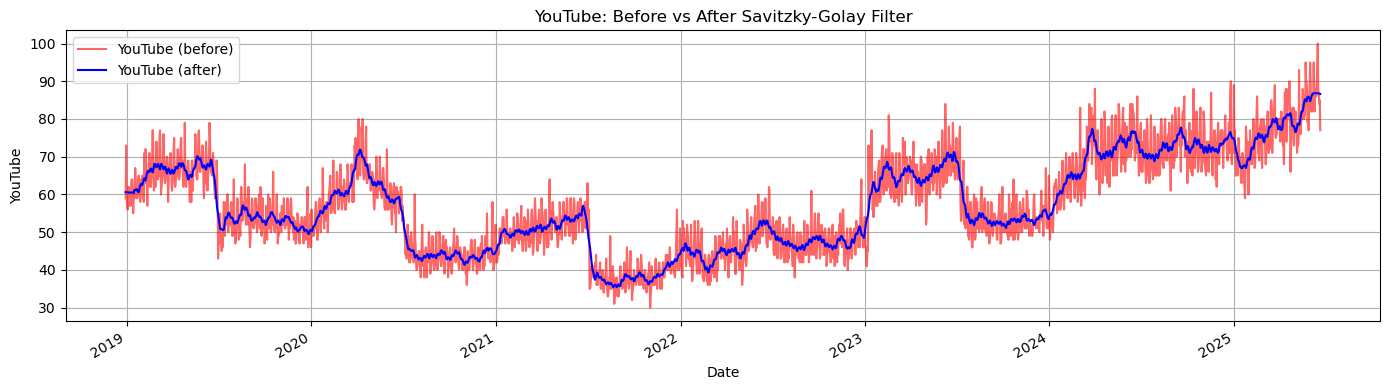

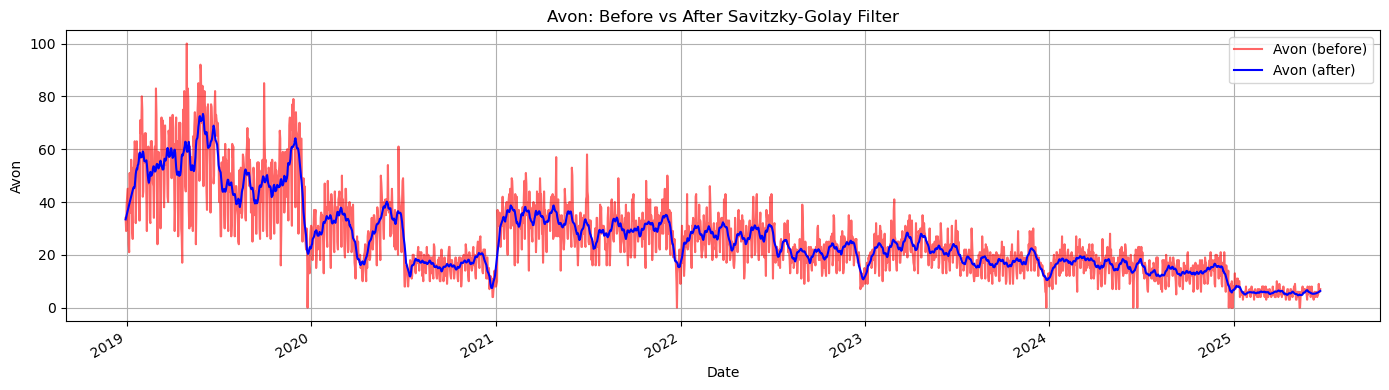

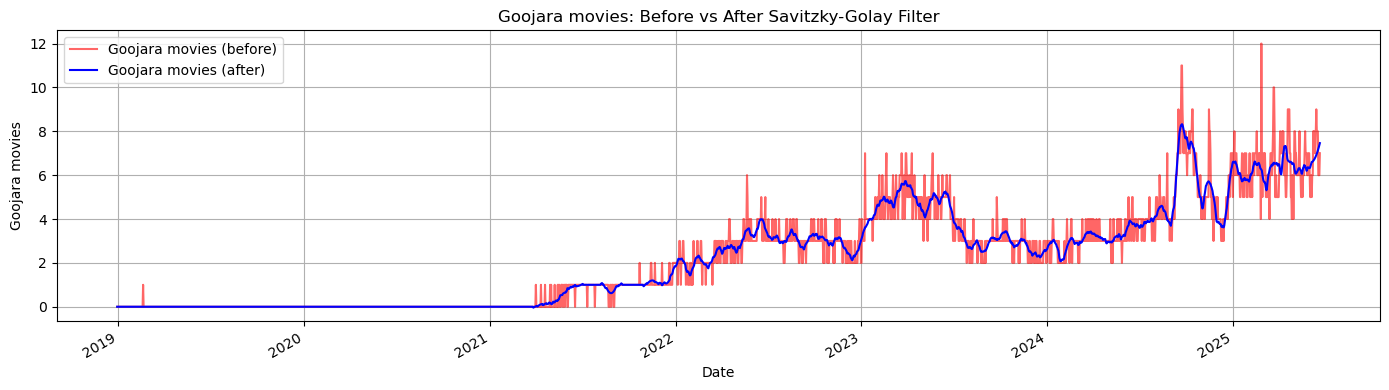

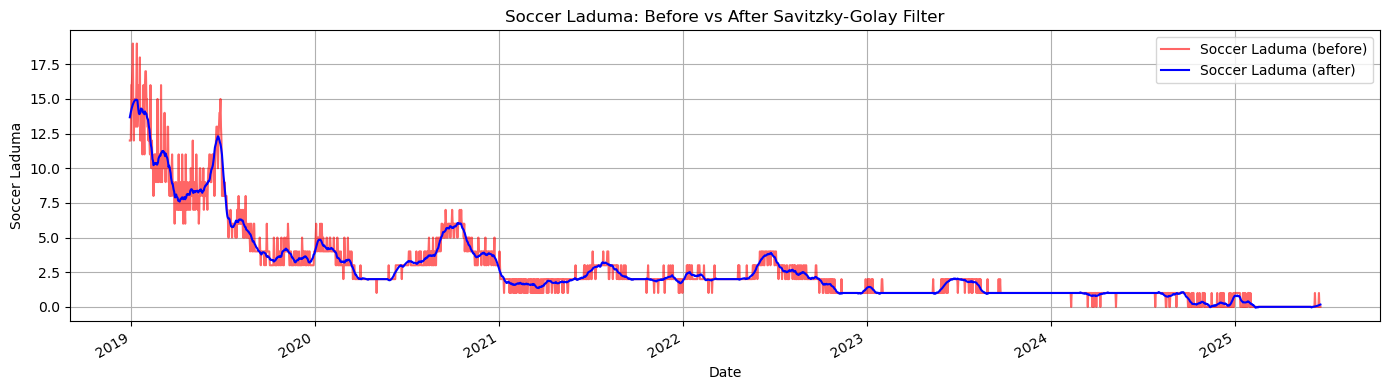

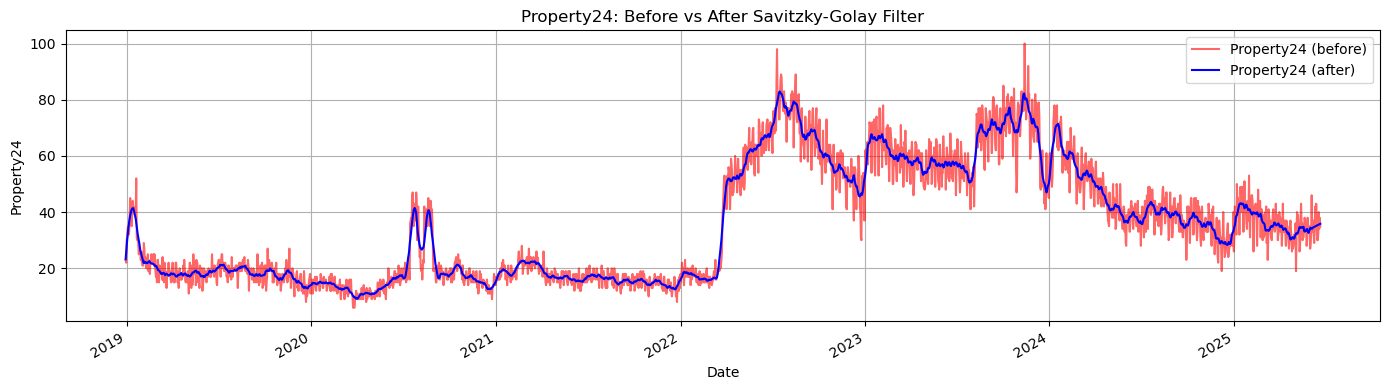

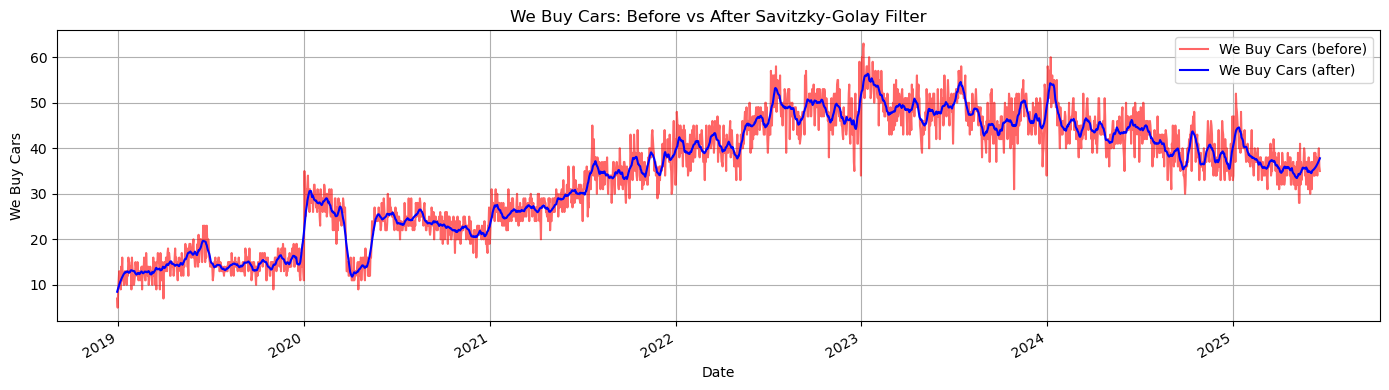

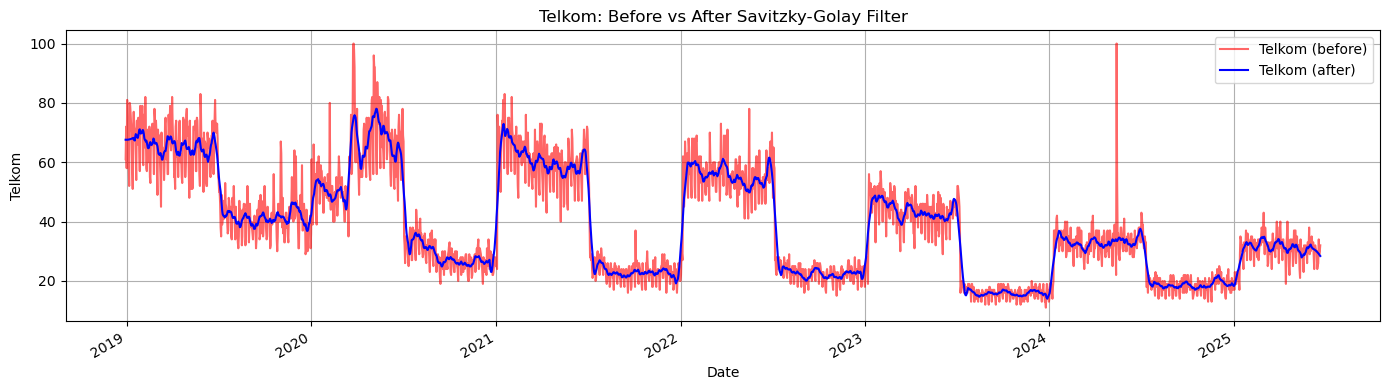

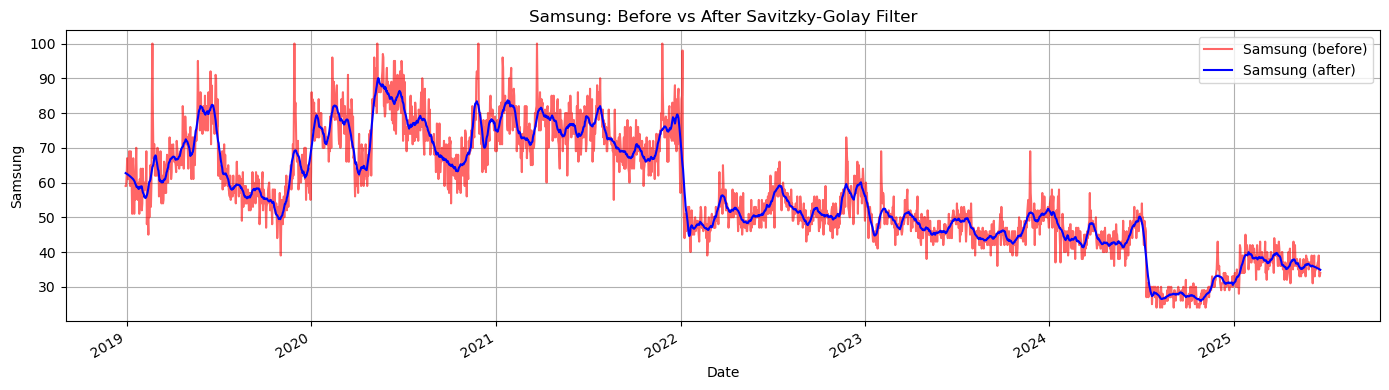

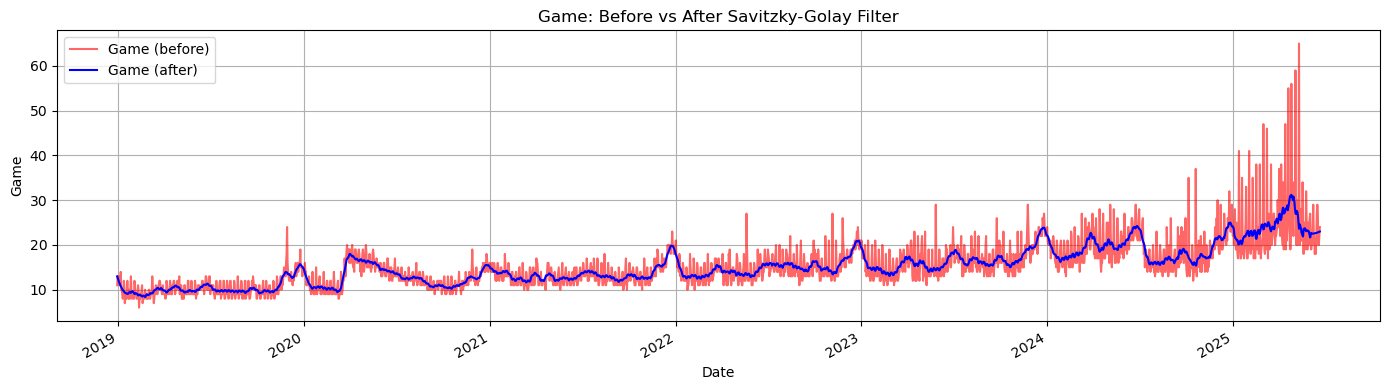

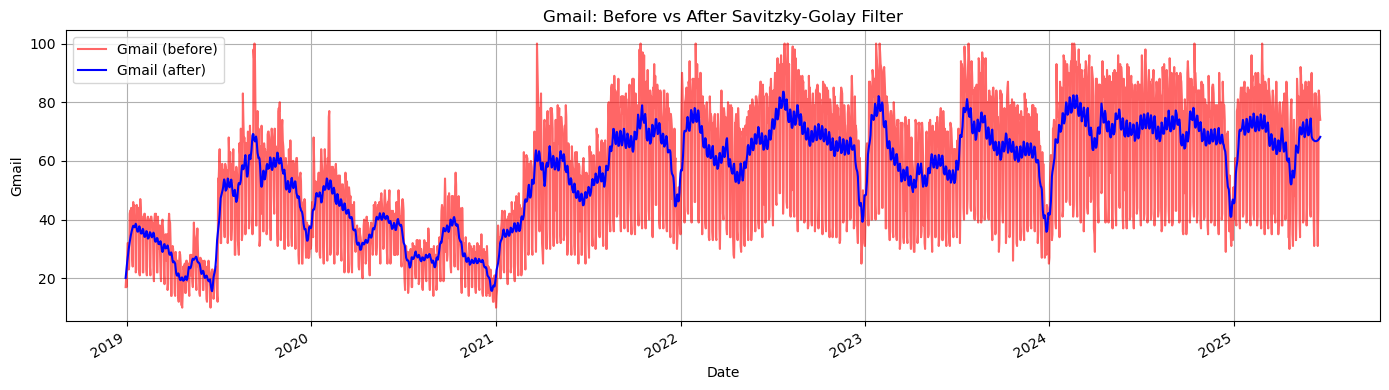

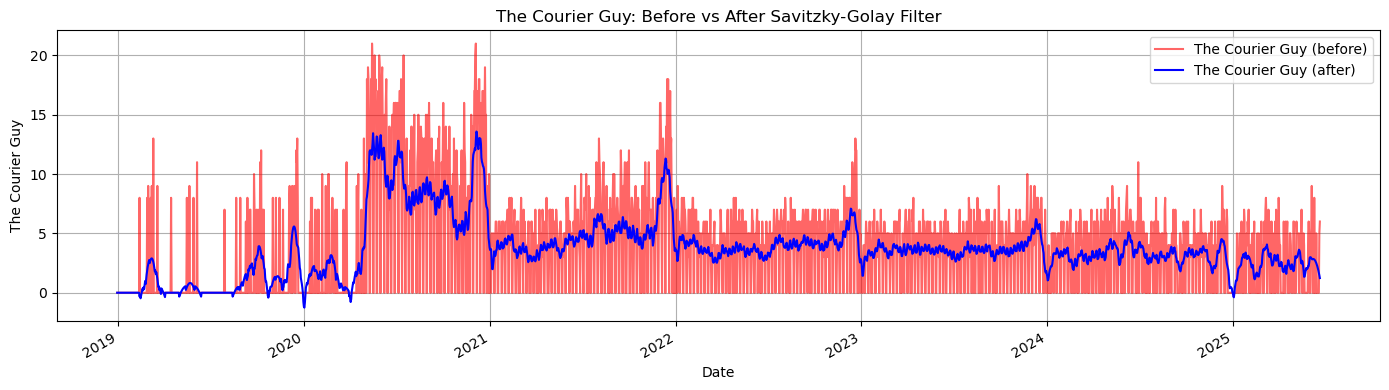

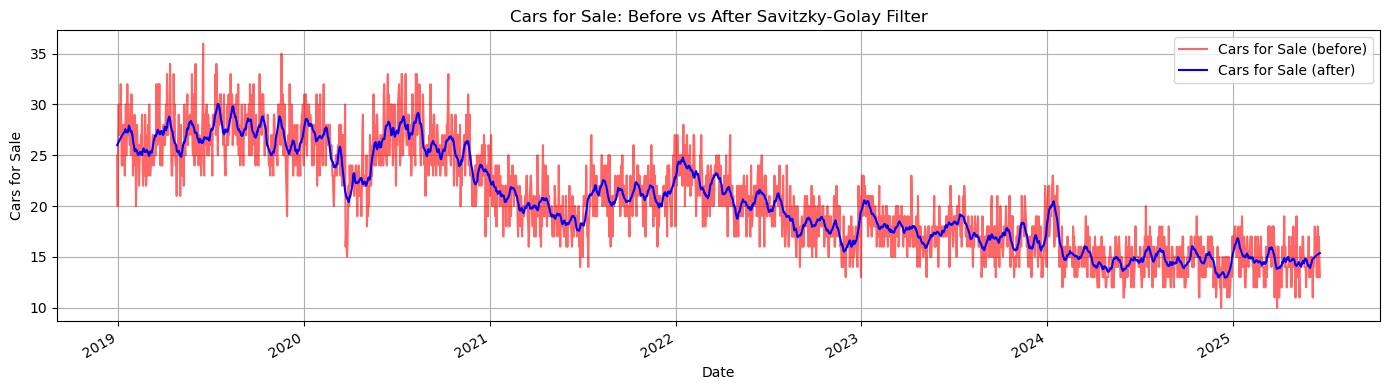

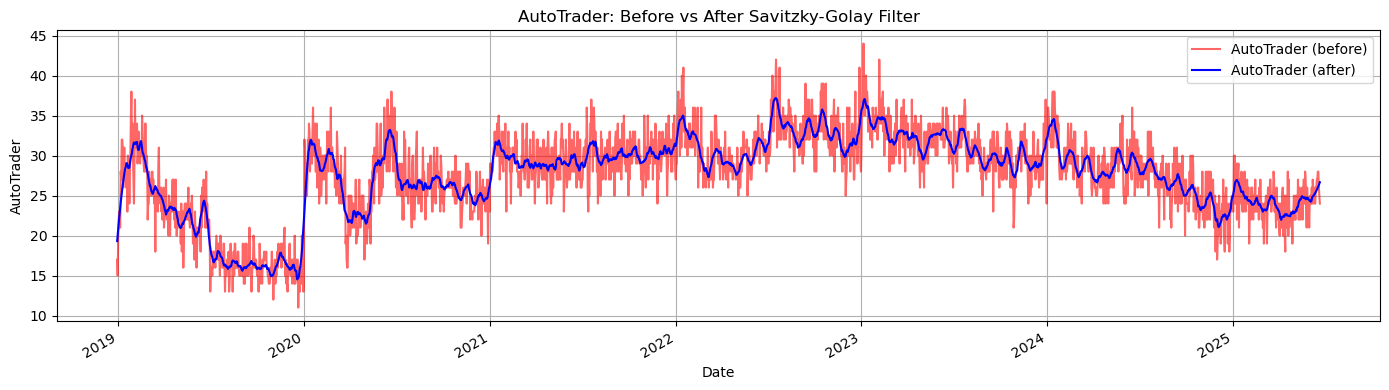

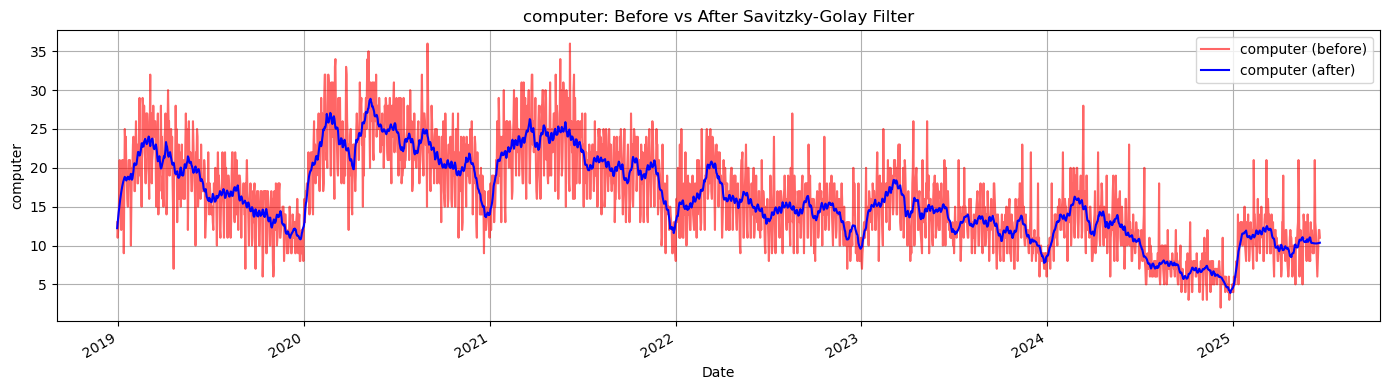

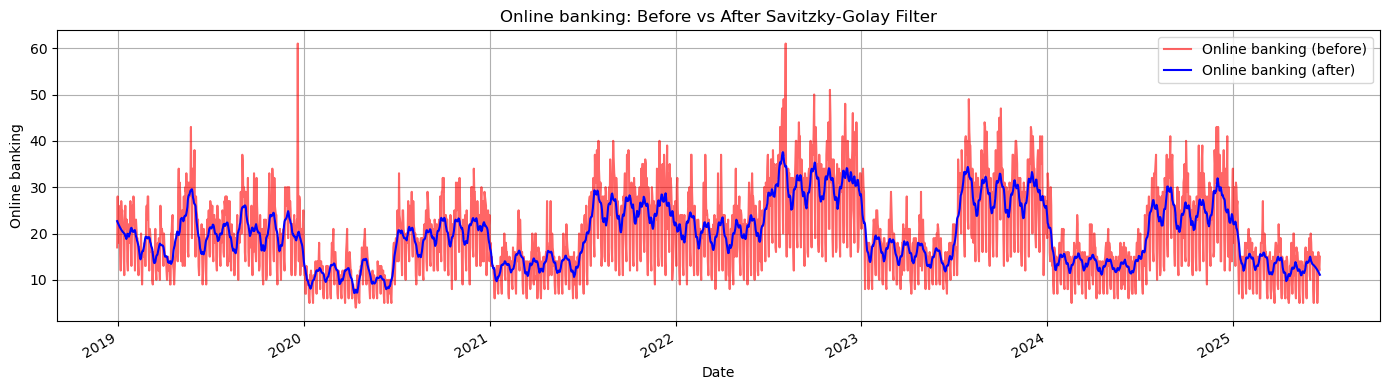

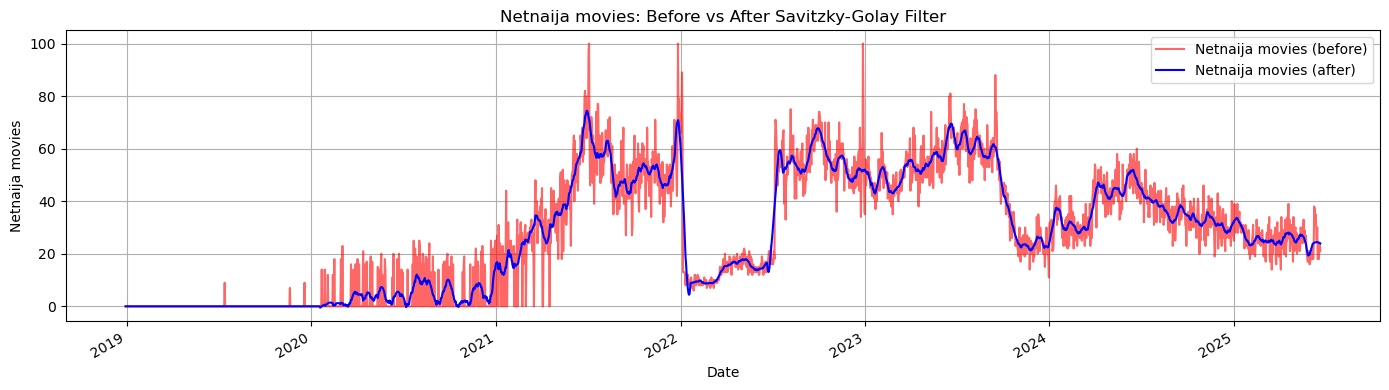

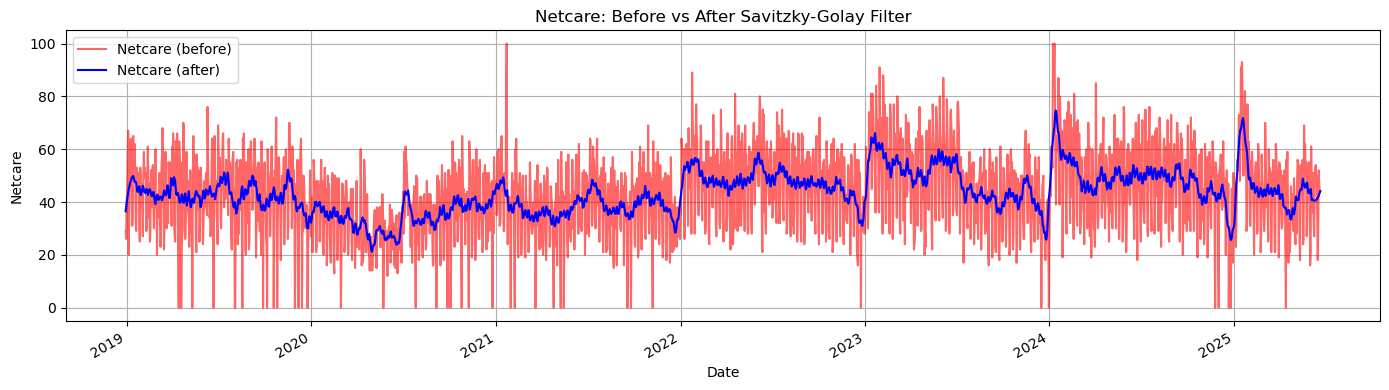

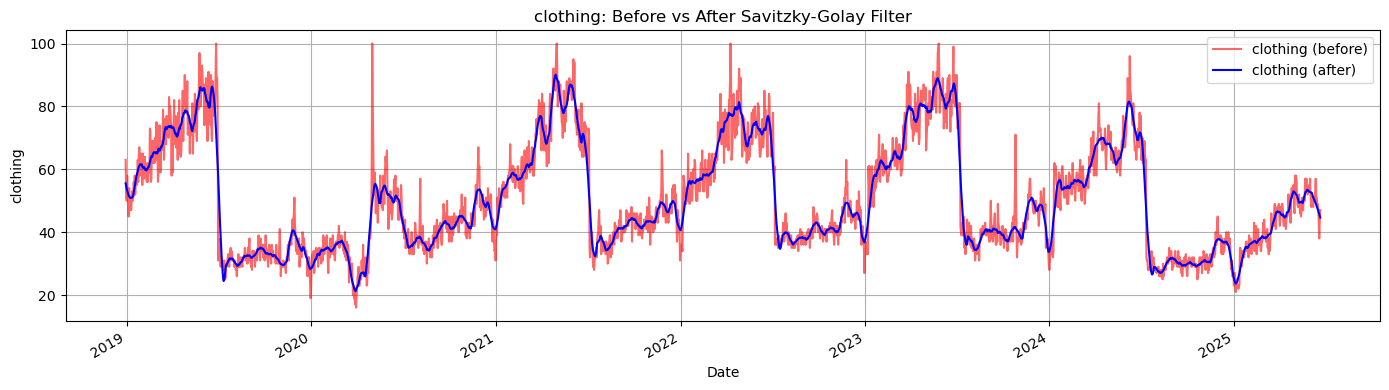

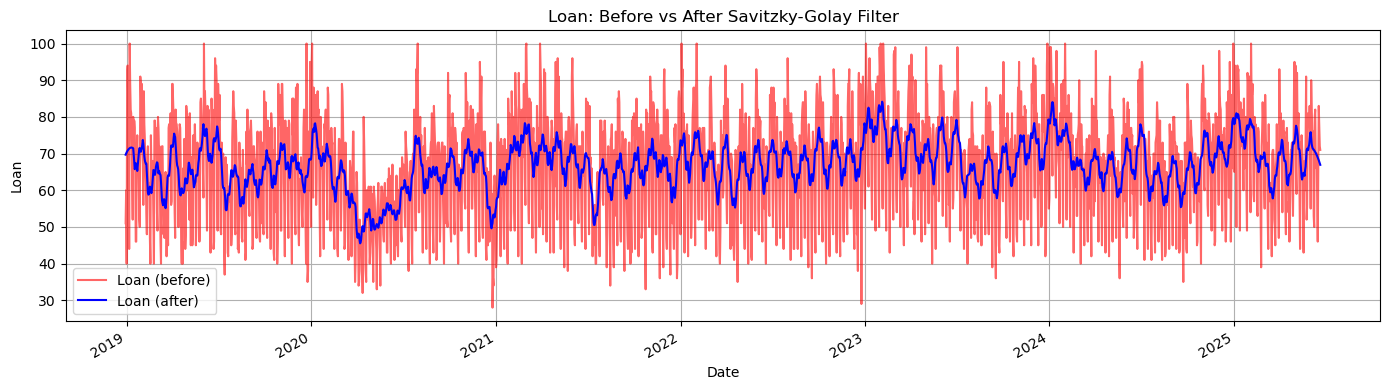

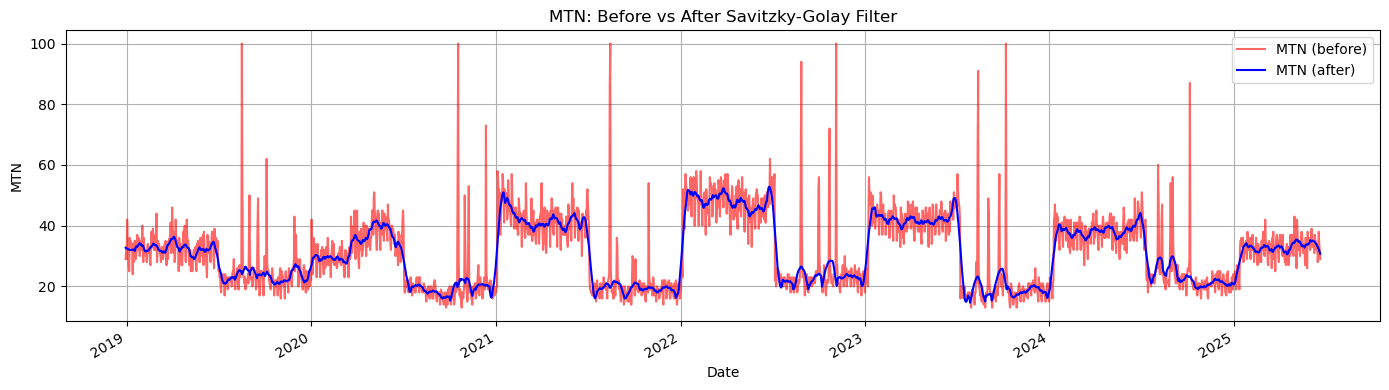

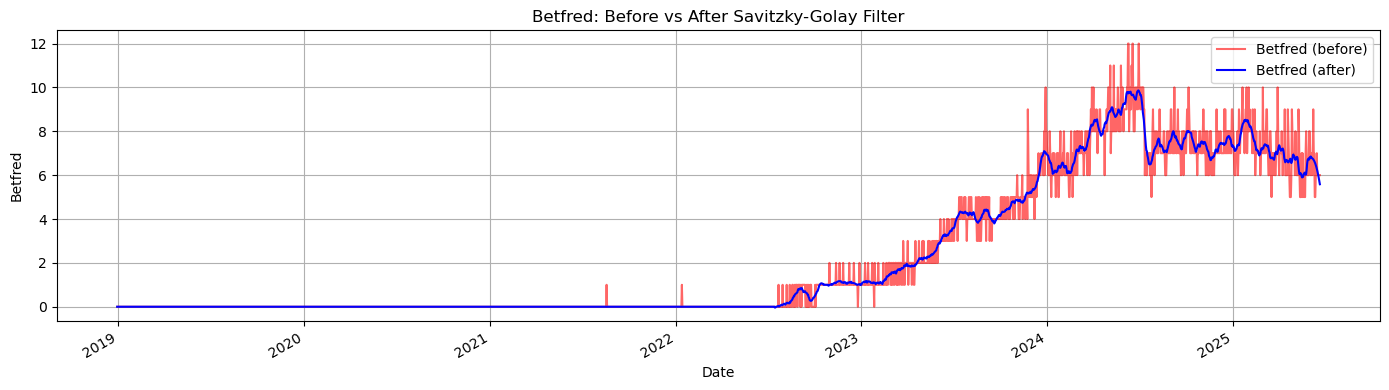

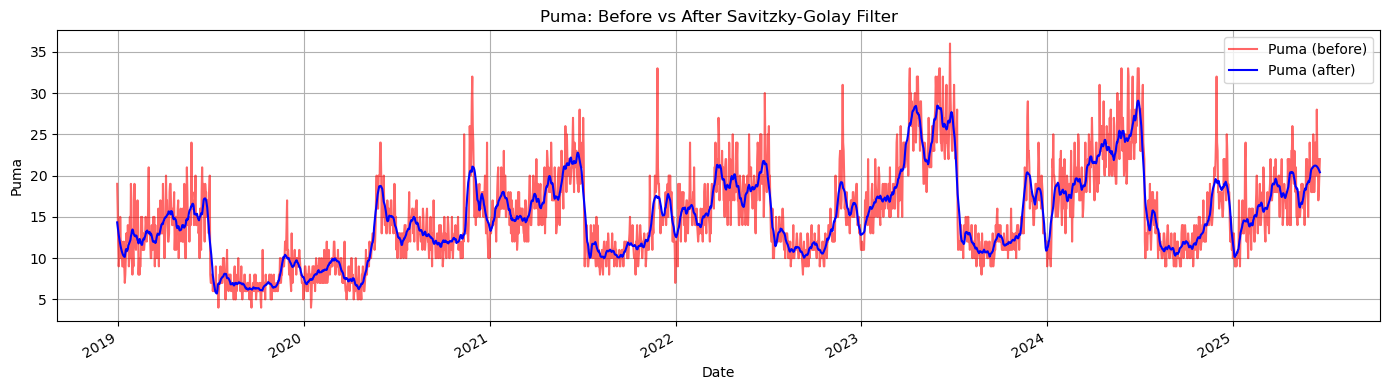

In [366]:
# Ensure 'date' is datetime
data['date'] = pd.to_datetime(data['date'])
data_cleaned['date'] = pd.to_datetime(data_cleaned['date'])

# Select numerical columns (excluding 'date')
num_cols = data.select_dtypes(include='number').columns

# Loop through each numerical column
for col in num_cols:
    plt.figure(figsize=(14, 4))
    plt.plot(data['date'], data[col], color='red', alpha=0.6, label=f'{col} (before)')
    plt.plot(data_cleaned['date'], data_cleaned[col], color='blue', label=f'{col} (after)')
    plt.title(f"{col}: Before vs After Savitzky-Golay Filter")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

In [367]:
df.head()

Date      Value  Value_lag1  Value_lag2
0  2019-01-01  75.124706   74.815789   74.518053
1  2019-01-02  75.444805   75.124706   74.815789
2  2019-01-03  75.776085   75.444805   75.124706
3  2019-01-04  76.118546   75.776085   75.444805
4  2019-01-05  76.472189   76.118546   75.776085

In [368]:
data_cleaned.head()

date   Football    YouTube       Avon  Goojara movies  Soccer Laduma  \
0 2018-12-30  66.634531  60.611804  33.418988             0.0      13.678152   
1 2018-12-31  66.006012  60.587830  34.237610             0.0      13.872361   
2 2019-01-01  65.403431  60.566789  35.051416             0.0      14.050478   
3 2019-01-02  64.826787  60.548680  35.860406             0.0      14.212504   
4 2019-01-03  64.276082  60.533504  36.664579             0.0      14.358439   

   Property24  We Buy Cars     Telkom    Samsung  ...  AutoTrader   computer  \
0   23.209311     8.488636  67.583211  62.716276  ...   19.314883  12.231672   
1   25.648900     8.888490  67.575440  62.627859  ...   20.080132  12.948240   
2   27.913207     9.271418  67.574684  62.535196  ...   20.819886  13.625346   
3   30.002230     9.637420  67.580943  62.438285  ...   21.534144  14.262989   
4   31.915970     9.986498  67.594218  62.337127  ...   22.222907  14.861169   

   Online banking  Netnaija movies    Netcare   clothing       Loan  \
0       22.669721              0.0  36.467009  55.531891  69.698680   
1       22.397067              0.0  38.095381  54.694868  70.028299   
2       22.136877              0.0  39.618599  53.940765  70.327455   
3       21.889150              0.0  41.036662  53.269582  70.596147   
4       21.653886              0.0  42.349570  52.681320  70.834377   

         MTN  Betfred       Puma  
0  32.736437      0.0  14.332478  
1  32.606891      0.0  13.800660  
2  32.490340      0.0  13.304879  
3  32.386783      0.0  12.845136  
4  32.296221      0.0  12.421430  

[5 rows x 24 columns]

In [369]:
# Reset index to align rows
merged_df = pd.concat([data_cleaned.reset_index(drop=True), df.reset_index(drop=True)], axis=1)

merged_df.head()


date   Football    YouTube       Avon  Goojara movies  Soccer Laduma  \
0 2018-12-30  66.634531  60.611804  33.418988             0.0      13.678152   
1 2018-12-31  66.006012  60.587830  34.237610             0.0      13.872361   
2 2019-01-01  65.403431  60.566789  35.051416             0.0      14.050478   
3 2019-01-02  64.826787  60.548680  35.860406             0.0      14.212504   
4 2019-01-03  64.276082  60.533504  36.664579             0.0      14.358439   

   Property24  We Buy Cars     Telkom    Samsung  ...    Netcare   clothing  \
0   23.209311     8.488636  67.583211  62.716276  ...  36.467009  55.531891   
1   25.648900     8.888490  67.575440  62.627859  ...  38.095381  54.694868   
2   27.913207     9.271418  67.574684  62.535196  ...  39.618599  53.940765   
3   30.002230     9.637420  67.580943  62.438285  ...  41.036662  53.269582   
4   31.915970     9.986498  67.594218  62.337127  ...  42.349570  52.681320   

        Loan        MTN  Betfred       Puma        Date      Value  \
0  69.698680  32.736437      0.0  14.332478  2019-01-01  75.124706   
1  70.028299  32.606891      0.0  13.800660  2019-01-02  75.444805   
2  70.327455  32.490340      0.0  13.304879  2019-01-03  75.776085   
3  70.596147  32.386783      0.0  12.845136  2019-01-04  76.118546   
4  70.834377  32.296221      0.0  12.421430  2019-01-05  76.472189   

   Value_lag1  Value_lag2  
0   74.815789   74.518053  
1   75.124706   74.815789  
2   75.444805   75.124706  
3   75.776085   75.444805  
4   76.118546   75.776085  

[5 rows x 28 columns]

In [370]:
# drop the duplicated Date column 
merged_df = merged_df.drop('Date', axis=1)

In [371]:
#set date as index 
merged_df = merged_df.set_index('date')

In [372]:
# Count missing values per column
missing_per_column = merged_df.isna().sum()
print(missing_per_column)

# Total missing values in the whole DataFrame
total_missing = missing_per_column.sum()
print(f'Total missing values: {total_missing}')

Football           0
YouTube            0
Avon               0
Goojara movies     0
Soccer Laduma      0
Property24         0
We Buy Cars        0
Telkom             0
Samsung            0
Game               0
Gmail              0
The Courier Guy    0
Cars for Sale      0
AutoTrader         0
computer           0
Online banking     0
Netnaija movies    0
Netcare            0
clothing           0
Loan               0
MTN                0
Betfred            0
Puma               0
Value              2
Value_lag1         2
Value_lag2         2
dtype: int64
Total missing values: 6


In [373]:
merged_df = merged_df.dropna()
print(f"Shape after dropping missing values: {merged_df.shape}")


Shape after dropping missing values: (2363, 26)


In [374]:
merged_df.head()

Football    YouTube       Avon  Goojara movies  Soccer Laduma  \
date                                                                         
2018-12-30  66.634531  60.611804  33.418988             0.0      13.678152   
2018-12-31  66.006012  60.587830  34.237610             0.0      13.872361   
2019-01-01  65.403431  60.566789  35.051416             0.0      14.050478   
2019-01-02  64.826787  60.548680  35.860406             0.0      14.212504   
2019-01-03  64.276082  60.533504  36.664579             0.0      14.358439   

            Property24  We Buy Cars     Telkom    Samsung       Game  ...  \
date                                                                  ...   
2018-12-30   23.209311     8.488636  67.583211  62.716276  12.982771  ...   
2018-12-31   25.648900     8.888490  67.575440  62.627859  12.617669  ...   
2019-01-01   27.913207     9.271418  67.574684  62.535196  12.270654  ...   
2019-01-02   30.002230     9.637420  67.580943  62.438285  11.941728  ...   
2019-01-03   31.915970     9.986498  67.594218  62.337127  11.630890  ...   

            Netnaija movies    Netcare   clothing       Loan        MTN  \
date                                                                      
2018-12-30              0.0  36.467009  55.531891  69.698680  32.736437   
2018-12-31              0.0  38.095381  54.694868  70.028299  32.606891   
2019-01-01              0.0  39.618599  53.940765  70.327455  32.490340   
2019-01-02              0.0  41.036662  53.269582  70.596147  32.386783   
2019-01-03              0.0  42.349570  52.681320  70.834377  32.296221   

            Betfred       Puma      Value  Value_lag1  Value_lag2  
date                                                               
2018-12-30      0.0  14.332478  75.124706   74.815789   74.518053  
2018-12-31      0.0  13.800660  75.444805   75.124706   74.815789  
2019-01-01      0.0  13.304879  75.776085   75.444805   75.124706  
2019-01-02      0.0  12.845136  76.118546   75.776085   75.444805  
2019-01-03      0.0  12.421430  76.472189   76.118546   75.776085  

[5 rows x 26 columns]

In [375]:
len(merged_df.columns)

26

In [376]:

# --- Separate features and target ---
features = [col for col in merged_df.columns if col != 'Value']  # X
target = ['Value']  # y


# --- Initialize scalers ---
scaler_X = MinMaxScaler()  # scale features
scaler_y = MinMaxScaler()  # scale log-transformed target

# --- Scale features and log-transformed target separately ---
X_scaled = scaler_X.fit_transform(merged_df[features])
y_scaled = scaler_y.fit_transform(merged_df[['Value']])

# --- Convert back to DataFrame (optional) ---
X_scaled_df = pd.DataFrame(X_scaled, columns=features, index=merged_df.index)
y_scaled_df = pd.DataFrame(y_scaled, columns=target, index=merged_df.index) 

In [377]:
y_scaled_df.shape

(2363, 1)

In [378]:
X_scaled_df.shape

(2363, 25)

In [379]:
X_scaled_df

Football   YouTube      Avon  Goojara movies  Soccer Laduma  \
date                                                                      
2018-12-30  0.872309  0.489898  0.418630        0.004908       0.915393   
2018-12-31  0.863671  0.489431  0.430547        0.004908       0.928335   
2019-01-01  0.855389  0.489022  0.442393        0.004908       0.940205   
2019-01-02  0.847464  0.488670  0.454169        0.004908       0.951002   
2019-01-03  0.839896  0.488375  0.465876        0.004908       0.960728   
...              ...       ...       ...             ...            ...   
2025-06-14  0.202117  0.999556  0.013770        0.839290       0.008947   
2025-06-15  0.189796  0.999189  0.015134        0.847341       0.009782   
2025-06-16  0.175910  0.998713  0.016655        0.856001       0.010670   
2025-06-17  0.160459  0.998126  0.018333        0.865269       0.011612   
2025-06-18  0.143443  0.997431  0.020167        0.875147       0.012609   

            Property24  We Buy Cars    Telkom   Samsung      Game  ...  \
date                                                               ...   
2018-12-30    0.191065     0.000000  0.836738  0.573521  0.201322  ...   
2018-12-31    0.224117     0.008353  0.836617  0.572141  0.185326  ...   
2019-01-01    0.254795     0.016353  0.836605  0.570696  0.170122  ...   
2019-01-02    0.283098     0.023999  0.836703  0.569184  0.155711  ...   
2019-01-03    0.309026     0.031291  0.836910  0.567606  0.142093  ...   
...                ...          ...       ...       ...       ...  ...   
2025-06-14    0.354834     0.581116  0.245616  0.147208  0.628223  ...   
2025-06-15    0.356079     0.585564  0.242629  0.146031  0.629906  ...   
2025-06-16    0.357322     0.590329  0.239451  0.144823  0.631725  ...   
2025-06-17    0.358561     0.595411  0.236081  0.143585  0.633681  ...   
2025-06-18    0.359797     0.600809  0.232521  0.142317  0.635772  ...   

            Online banking  Netnaija movies   Netcare  clothing      Loan  \
date                                                                        
2018-12-30        0.510385         0.006578  0.286508  0.498040  0.625828   
2018-12-31        0.501410         0.006578  0.316961  0.485888  0.634362   
2019-01-01        0.492845         0.006578  0.345446  0.474938  0.642107   
2019-01-02        0.484691         0.006578  0.371966  0.465193  0.649064   
2019-01-03        0.476946         0.006578  0.396518  0.456652  0.655232   
...                    ...              ...       ...       ...       ...   
2025-06-14        0.168840         0.332661  0.376191  0.385520  0.614946   
2025-06-15        0.163031         0.332236  0.382406  0.378467  0.606162   
2025-06-16        0.156906         0.331544  0.389711  0.371201  0.596844   
2025-06-17        0.150464         0.330582  0.398106  0.363721  0.586993   
2025-06-18        0.143705         0.329353  0.407591  0.356028  0.576608   

                 MTN   Betfred      Puma  Value_lag1  Value_lag2  
date                                                              
2018-12-30  0.473677  0.004146  0.368931    0.489023    0.483902  
2018-12-31  0.470287  0.004146  0.346170    0.494336    0.489023  
2019-01-01  0.467237  0.004146  0.324952    0.499842    0.494336  
2019-01-02  0.464528  0.004146  0.305275    0.505539    0.499842  
2019-01-03  0.462158  0.004146  0.287142    0.511430    0.505539  
...              ...       ...       ...         ...         ...  
2025-06-14  0.490248  0.639464  0.659159    0.068923    0.057161  
2025-06-15  0.480995  0.629761  0.656117    0.082061    0.068923  
2025-06-16  0.470876  0.619183  0.652257    0.096575    0.082061  
2025-06-17  0.459891  0.607729  0.647579    0.112467    0.096575  
2025-06-18  0.448042  0.595399  0.642083    0.129734    0.112467  

[2363 rows x 25 columns]

In [380]:
# 80/20 split
train_size = int(len(X_scaled_df) * 0.8)

# Split features (X) and target (y)
X_train_arimax = X_scaled_df.iloc[:train_size]
X_test_arimax  = X_scaled_df.iloc[train_size:]

y_train_arimax = y_scaled_df.iloc[:train_size]
y_test_arimax  = y_scaled_df.iloc[train_size:]

# Quick check
print("X_train shape:", X_train_arimax.shape)
print("X_test shape:", X_test_arimax.shape)
print("y_train shape:", y_train_arimax.shape)
print("y_test shape:", y_test_arimax.shape)

X_train shape: (1890, 25)
X_test shape: (473, 25)
y_train shape: (1890, 1)
y_test shape: (473, 1)


In [381]:
# Function to create sequences
def create_sequences(X, y, seq_length=7):
    X_seq, y_seq = [], []
    for i in range(seq_length, len(X)):
        X_seq.append(X.iloc[i-seq_length:i].values)  # sequence of features
        y_seq.append(y.iloc[i].values if y.ndim > 1 else y.iloc[i])  # target
    return np.array(X_seq), np.array(y_seq)

seq_length = 30 

# Create train/test sequences
X_train_dl, y_train_dl = create_sequences(X_scaled_df.iloc[:train_size], y_scaled_df.iloc[:train_size], seq_length)
X_test_dl, y_test_dl   = create_sequences(X_scaled_df.iloc[train_size:], y_scaled_df.iloc[train_size:], seq_length)

# Print shapes for checking
print("X_train shape:", X_train_dl.shape)
print("y_train shape:", y_train_dl.shape)
print("X_test shape:", X_test_dl.shape)
print("y_test shape:", y_test_dl.shape)


X_train shape: (1860, 30, 25)
y_train shape: (1860, 1)
X_test shape: (443, 30, 25)
y_test shape: (443, 1)


# ARIMAX

In [382]:
# Fit ARIMAX model
arimax_model = SARIMAX(
    y_train_arimax,
    exog=X_train_arimax,
    order=(3,0,2),          
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

print(arimax_model.summary())




                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                 1890
Model:               SARIMAX(3, 0, 2)   Log Likelihood                6035.536
Date:                Tue, 16 Sep 2025   AIC                         -12009.072
Time:                        02:30:41   BIC                         -11837.247
Sample:                    12-30-2018   HQIC                        -11945.795
                         - 03-02-2024                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Football            0.0076      0.003      3.012      0.003       0.003       0.013
YouTube             0.0006      0.004      0.161      0.872      -0.007       0.008
Avon               -0.0027      

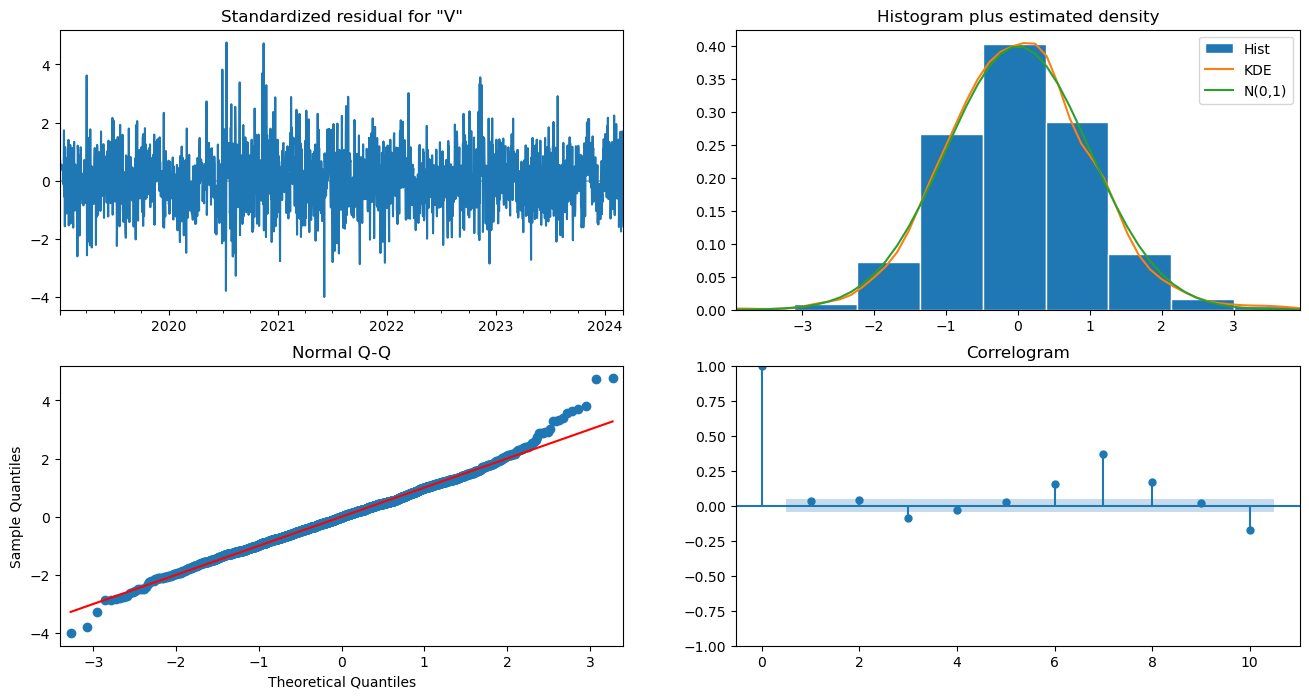

In [383]:
arimax_model.plot_diagnostics(figsize=(16, 8))
plt.show()


In [384]:
# Forecast
forecast_arimax = arimax_model.get_forecast(steps=len(y_test_arimax), exog=X_test_arimax)
forecast_values = forecast_arimax.predicted_mean
conf_int = forecast_arimax.conf_int()

# Evaluate
rmse_arimax = np.sqrt(mean_squared_error(y_test_arimax, forecast_values))
mae_arimax = mean_absolute_error(y_test_arimax, forecast_values)
r2_arimax = r2_score(y_test_arimax, forecast_values)

print(f"ARIMAX -> RMSE: {rmse_arimax:.4f}, MAE: {mae_arimax:.4f}, R²: {r2_arimax:.4f}")

ARIMAX -> RMSE: 0.0129, MAE: 0.0101, R²: 0.9977


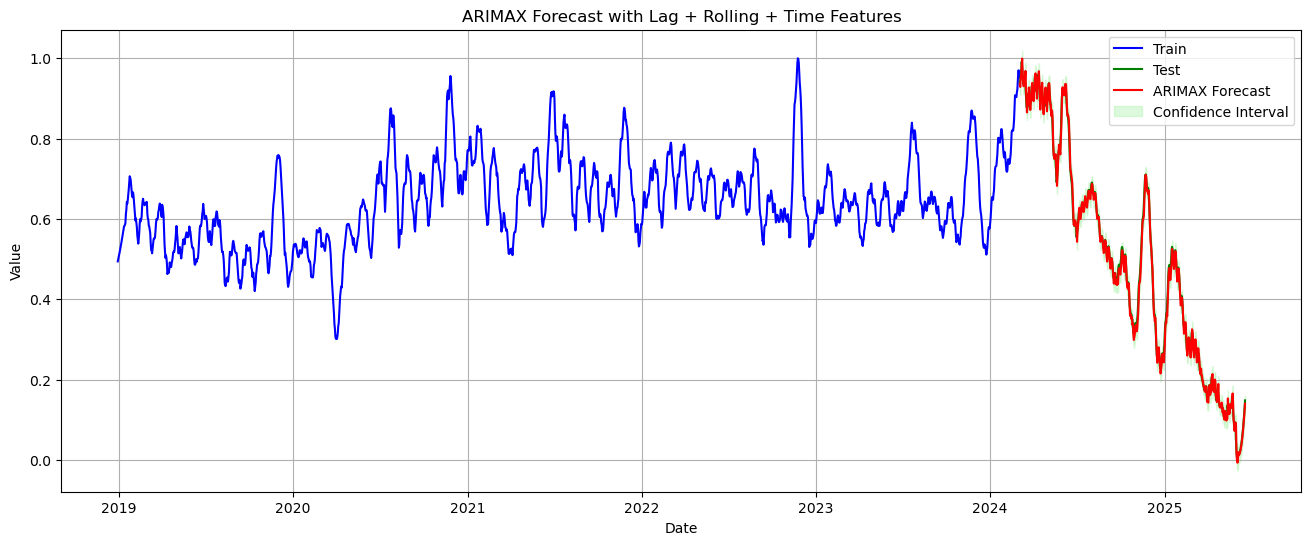

In [385]:
plt.figure(figsize=(16,6))
# Train
plt.plot(y_train_arimax.index, y_train_arimax, label='Train', color='blue')
# Test
plt.plot(y_test_arimax.index, y_test_arimax, label='Test', color='green')
# ARIMAX Forecast
plt.plot(y_test_arimax.index, forecast_values, color='red', label='ARIMAX Forecast')

# Confidence interval
plt.fill_between(
    y_test_arimax.index, 
    conf_int.iloc[:, 0], 
    conf_int.iloc[:, 1], 
    color='lightgreen', 
    alpha=0.3, 
    label='Confidence Interval'
)

plt.title("ARIMAX Forecast with Lag + Rolling + Time Features")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


# LSTM

In [386]:
#HELPING FUCTIONS 

def plot_history(histories, names):
    plt.figure(figsize=(18,6))
    for i, history in enumerate(histories):
        plt.plot(history.history['loss'], label=f'{names[i]} Train Loss')
        plt.plot(history.history['val_loss'], label=f'{names[i]} Val Loss', linestyle='--')
    plt.title('Deep Learning Model Training History (MSE Loss)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
def evaluate_model(model, X_test, y_test):
    pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    return rmse, mae, r2

# EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',    
    patience=10,            
    restore_best_weights=True 
)



#parameters
Epochs = 100
Batch_size=64
n_features = X_train_dl.shape[2] 

In [387]:
def build_lstm():
    model = Sequential()
    model.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train_dl.shape[1], n_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

lstm_model = build_lstm()
history_lstm = lstm_model.fit(X_train_dl, y_train_dl,
                               validation_data=(X_test_dl, y_test_dl), 
                               epochs=Epochs,
                                 batch_size=Batch_size,
                                  callbacks=[early_stop])
                              


Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.1041 - val_loss: 0.0613
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0175 - val_loss: 0.0595
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0137 - val_loss: 0.0622
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0126 - val_loss: 0.0528
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0119 - val_loss: 0.0490
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0109 - val_loss: 0.0491
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0104 - val_loss: 0.0300
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0099 - val_loss: 0.0408
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0093 - val_loss: 0.0247
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0096 - val_loss: 0.0265
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0088 - val_loss: 0.0251
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

In [388]:

rmse_lstm, mae_lstm, r2_lstm = evaluate_model(lstm_model, X_test_dl, y_test_dl)
# Print results
print(f"LSTM Model Performance:")
print(f"RMSE: {rmse_lstm:.4f}")
print(f"MAE: {mae_lstm:.4f}")
print(f"R²: {r2_lstm:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
LSTM Model Performance:
RMSE: 0.1110
MAE: 0.0927
R²: 0.8088


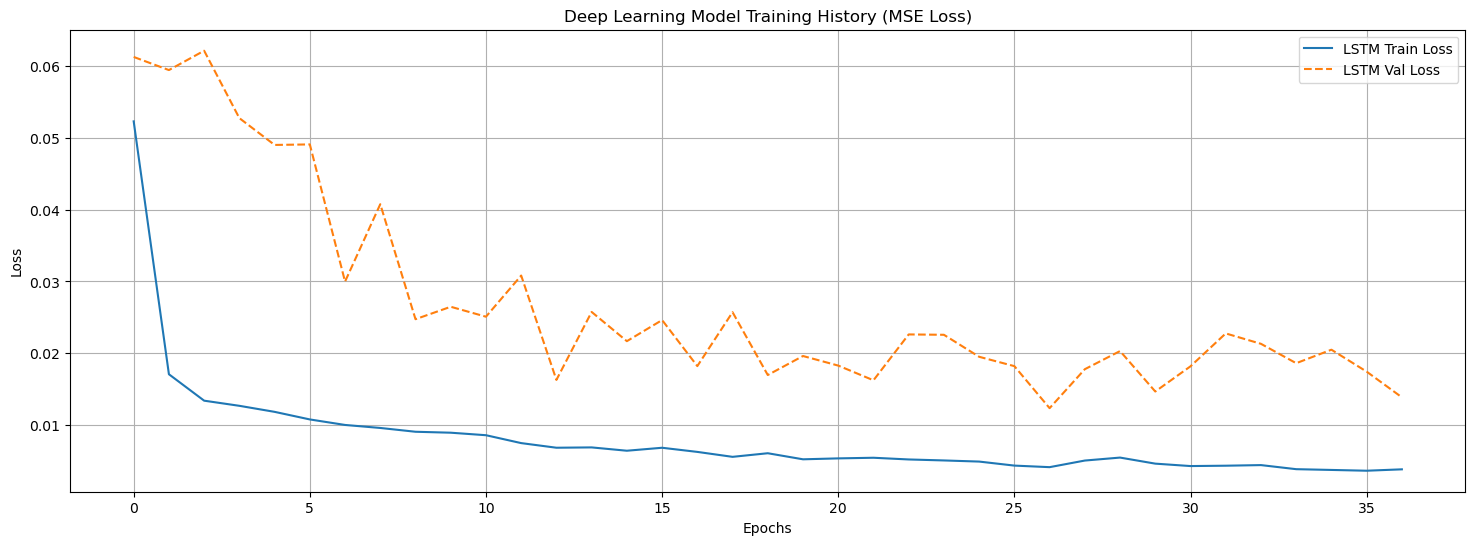

In [389]:
# Call the function
plot_history(
    histories=[history_lstm],
    names=['LSTM']
)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


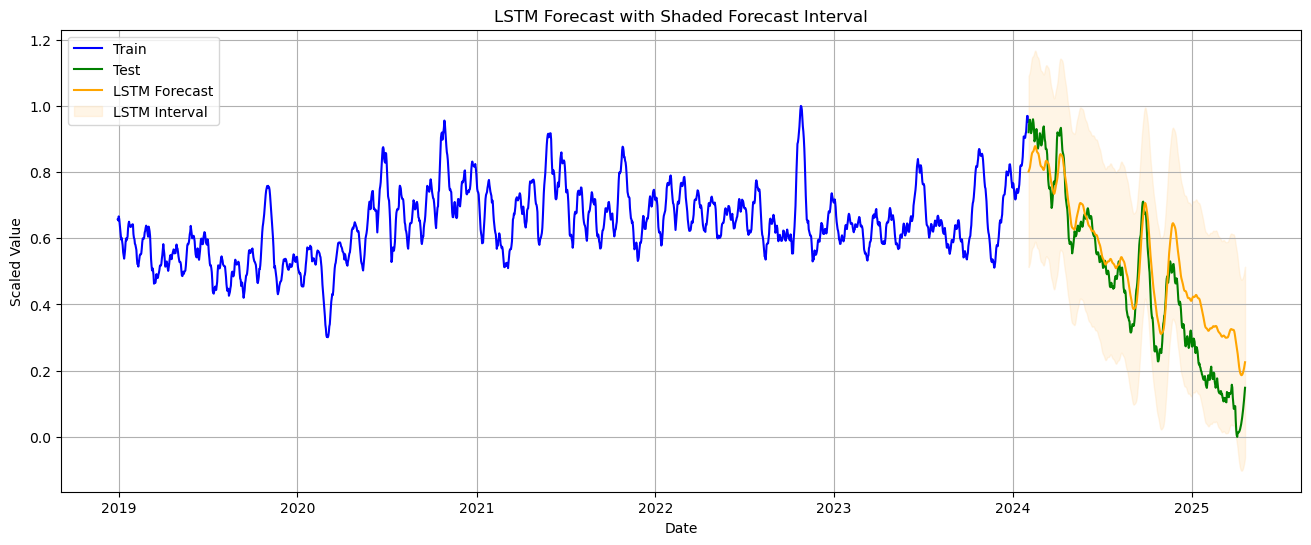

In [390]:
# --------------------------
# LSTM Forecast with Uncertainty (using merged_df)
# --------------------------
y_pred_lstm = lstm_model.predict(X_test_dl).flatten()

# Compute rolling std on train residuals
residuals_lstm = y_train_dl - lstm_model.predict(X_train_dl).flatten()
rolling_std_lstm = np.std(residuals_lstm)

# Confidence bounds
upper_bound_lstm = y_pred_lstm + 2 * rolling_std_lstm
lower_bound_lstm = y_pred_lstm - 2 * rolling_std_lstm

plt.figure(figsize=(16,6))
plt.plot(merged_df.index[:len(y_train_dl)], y_train_dl, label='Train', color='blue')
plt.plot(merged_df.index[len(y_train_dl):len(y_train_dl)+len(y_test_dl)], y_test_dl, label='Test', color='green')
plt.plot(merged_df.index[len(y_train_dl):len(y_train_dl)+len(y_test_dl)], y_pred_lstm, label='LSTM Forecast', color='orange')
plt.fill_between(
    merged_df.index[len(y_train_dl):len(y_train_dl)+len(y_test_dl)],
    lower_bound_lstm,
    upper_bound_lstm,
    color='navajowhite',
    alpha=0.3,
    label='LSTM Interval'
)
plt.title("LSTM Forecast with Shaded Forecast Interval")
plt.xlabel("Date")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)
plt.show()


In [391]:
n_display = 10
actual = y_test_dl[:n_display].flatten()
predicted = y_pred_lstm[:n_display].flatten()

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual': actual,
    'Predicted': predicted
})

print(comparison_df)

     Actual  Predicted
0  0.920523   0.801838
1  0.944328   0.805933
2  0.958010   0.810364
3  0.958029   0.816852
4  0.946591   0.826703
5  0.917580   0.838235
6  0.922507   0.849068
7  0.931615   0.856715
8  0.945890   0.860054
9  0.959734   0.861619


# GRU

In [392]:
def build_gru():
    model = Sequential()

    # First GRU layer
    model.add(GRU(
        128, activation='tanh', return_sequences=True,
        input_shape=(X_train_dl.shape[1], n_features),
        kernel_regularizer=regularizers.l2(0.001),   # L2 regularization
        recurrent_regularizer=regularizers.l2(0.001) # Regularize hidden state
    ))
    model.add(Dropout(0.3))

    # Second GRU layer
    model.add(GRU(
        64, activation='tanh', return_sequences=True,
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(Dropout(0.3))

    # Third GRU layer
    model.add(GRU(
        32, activation='tanh',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(Dropout(0.2))

    # Dense layers
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # output layer

    model.compile(optimizer='adam', loss='mse')
    return model
gru_model = build_lstm()
history_gru = gru_model.fit(X_train_dl, y_train_dl, 
                            validation_data=(X_test_dl, y_test_dl),
                            epochs= Epochs,
                            callbacks=[early_stop],
                            batch_size=Batch_size)


Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0967 - val_loss: 0.0595
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0174 - val_loss: 0.0463
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0136 - val_loss: 0.0410
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0118 - val_loss: 0.0394
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0109 - val_loss: 0.0321
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0104 - val_loss: 0.0412
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0098 - val_loss: 0.0297
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0085 - val_loss: 0.0230
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0093 - val_loss: 0.0245
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0097 - val_loss: 0.0244
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0072 - val_loss: 0.0221
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

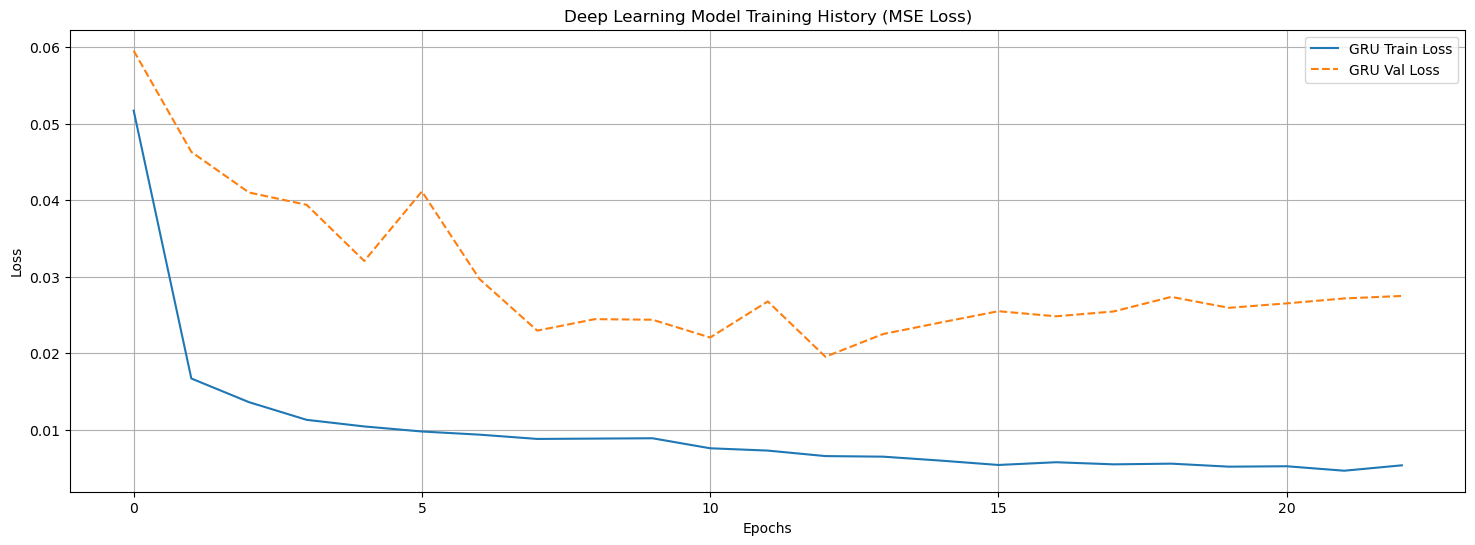

In [393]:
# Call the function
plot_history(
    histories=[history_gru],
    names=[ 'GRU']
)

In [394]:

rmse_gru, mae_gru, r2_gru = evaluate_model(gru_model, X_test_dl, y_test_dl)
# Print results
print(f"GRU Model Performance:")
print(f"RMSE: {rmse_gru:.4f}")
print(f"MAE: {mae_gru:.4f}")
print(f"R²: {r2_gru:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
GRU Model Performance:
RMSE: 0.1398
MAE: 0.1141
R²: 0.6967


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


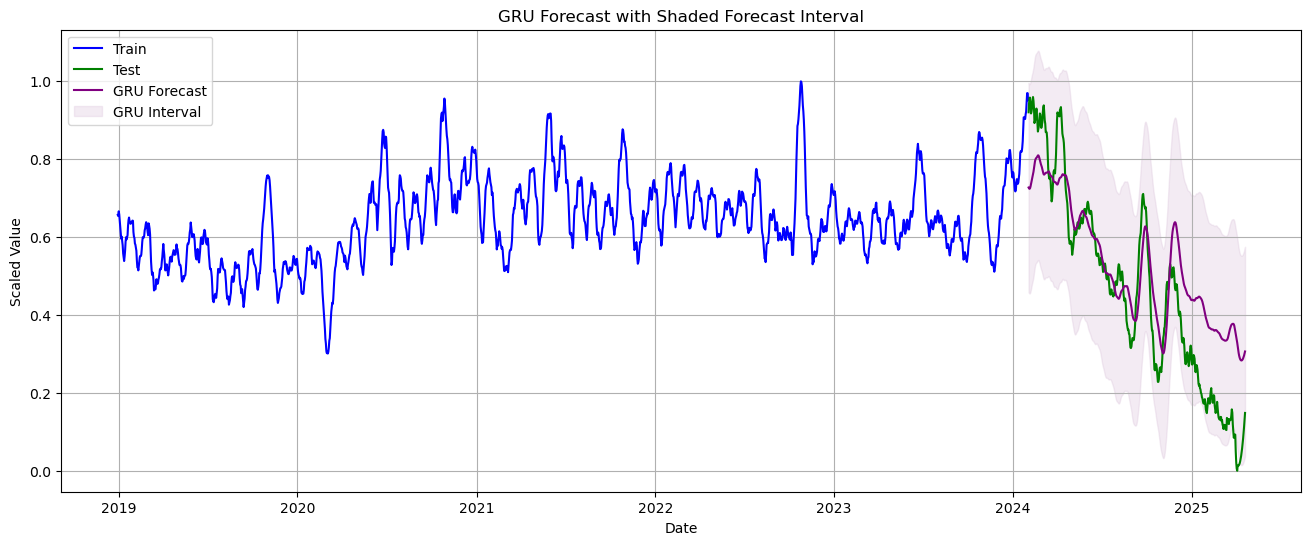

In [395]:
# GRU Forecast
y_pred_gru = gru_model.predict(X_test_dl).flatten()

residuals_gru = y_train_dl - gru_model.predict(X_train_dl).flatten()
rolling_std_gru = np.std(residuals_gru)

upper_bound_gru = y_pred_gru + 2 * rolling_std_gru
lower_bound_gru = y_pred_gru - 2 * rolling_std_gru

plt.figure(figsize=(16,6))
plt.plot(merged_df.index[:len(y_train_dl)], y_train_dl, label='Train', color='blue')
plt.plot(merged_df.index[len(y_train_dl):len(y_train_dl)+len(y_test_dl)], y_test_dl, label='Test', color='green')
plt.plot(merged_df.index[len(y_train_dl):len(y_train_dl)+len(y_test_dl)], y_pred_gru, label='GRU Forecast', color='purple')
plt.fill_between(
    merged_df.index[len(y_train_dl):len(y_train_dl)+len(y_test_dl)],
    lower_bound_gru,
    upper_bound_gru,
    color='thistle',
    alpha=0.3,
    label='GRU Interval'
)
plt.title("GRU Forecast with Shaded Forecast Interval")
plt.xlabel("Date")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)
plt.show()


# Bi-GRU 

In [396]:
def build_bigru():
    model = Sequential()
    model.add(Bidirectional(GRU(64, activation='tanh', return_sequences=True), input_shape=(X_train_dl.shape[1], n_features)))
    model.add(Dropout(0.2))
    model.add(GRU(32))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


bigru_model = build_bigru()
history_bigru = bigru_model.fit(X_train_dl, y_train_dl, 
                                validation_data=(X_test_dl, y_test_dl),
                                epochs=Epochs, batch_size=Batch_size,
                                callbacks=[early_stop])

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.1635 - val_loss: 0.0324
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0228 - val_loss: 0.0214
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0171 - val_loss: 0.0165
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0143 - val_loss: 0.0099
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0117 - val_loss: 0.0062
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0103 - val_loss: 0.0044
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0097 - val_loss: 0.0034
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0085 - val_loss: 0.0061
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0081 - val_loss: 0.0033
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0090 - val_loss: 0.0026
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0082 - val_loss: 0.0072
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

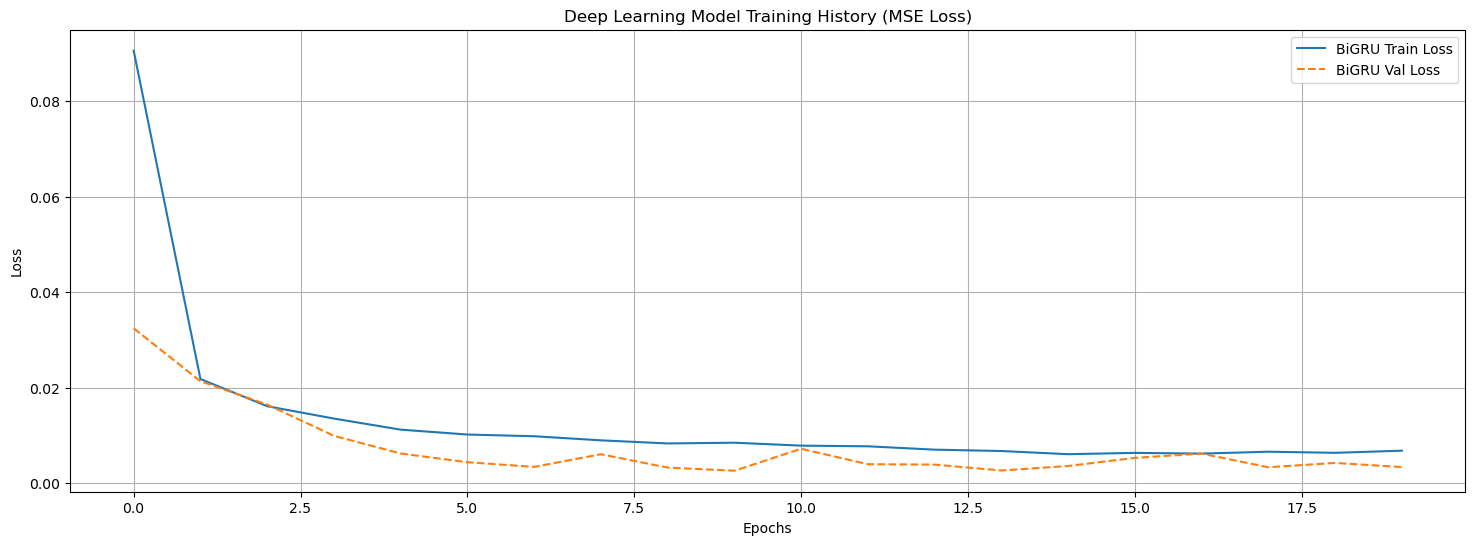

In [397]:
# Call the function
plot_history(
    histories=[history_bigru],
    names=['BiGRU']
)

In [398]:
rmse_bigru, mae_bigru, r2_bigru = evaluate_model(history_bigru.model, X_test_dl, y_test_dl)

# Print results
print(f"Bi-GRU Model Performance:")
print(f"RMSE: {rmse_bigru:.4f}")
print(f"MAE: {mae_bigru:.4f}")
print(f"R²: {r2_bigru:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Bi-GRU Model Performance:
RMSE: 0.0513
MAE: 0.0397
R²: 0.9591


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


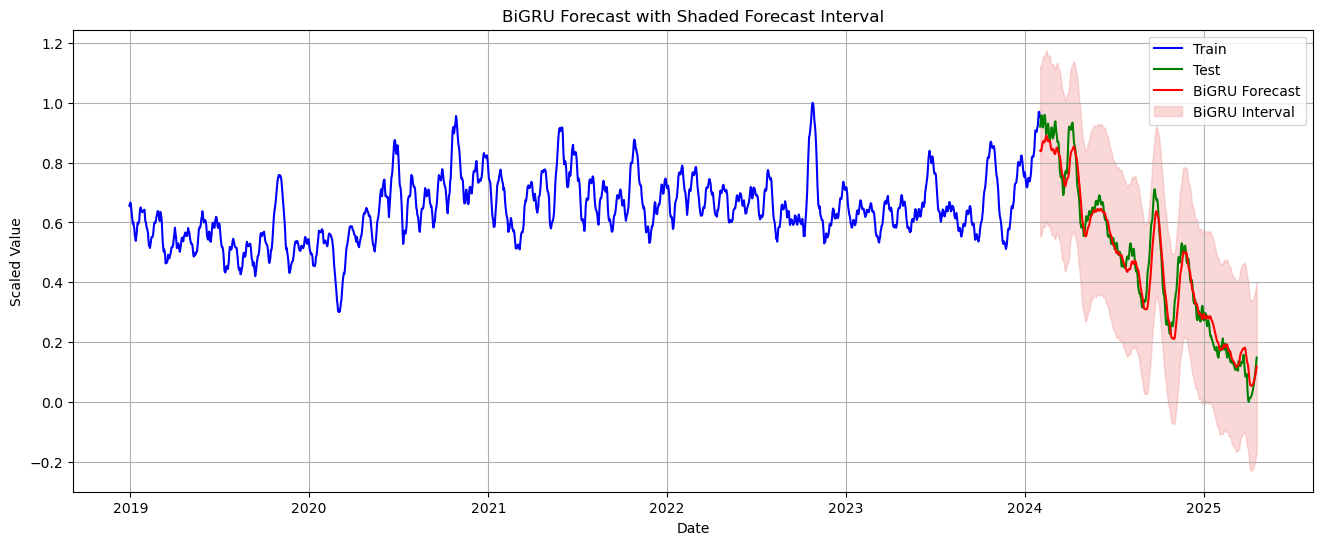

In [399]:
# BiGRU Forecast
y_pred_bigru = bigru_model.predict(X_test_dl).flatten()

residuals_bigru = y_train_dl - bigru_model.predict(X_train_dl).flatten()
rolling_std_bigru = np.std(residuals_bigru)

upper_bound_bigru = y_pred_bigru + 2 * rolling_std_bigru
lower_bound_bigru = y_pred_bigru - 2 * rolling_std_bigru

plt.figure(figsize=(16,6))
plt.plot(merged_df.index[:len(y_train_dl)], y_train_dl, label='Train', color='blue')
plt.plot(merged_df.index[len(y_train_dl):len(y_train_dl)+len(y_test_dl)], y_test_dl, label='Test', color='green')
plt.plot(merged_df.index[len(y_train_dl):len(y_train_dl)+len(y_test_dl)], y_pred_bigru, label='BiGRU Forecast', color='red')
plt.fill_between(
    merged_df.index[len(y_train_dl):len(y_train_dl)+len(y_test_dl)],
    lower_bound_bigru,
    upper_bound_bigru,
    color='lightcoral',
    alpha=0.3,
    label='BiGRU Interval'
)
plt.title("BiGRU Forecast with Shaded Forecast Interval")
plt.xlabel("Date")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)
plt.show()


In [400]:

metrics_df = pd.DataFrame({
    'Model': ['ARIMAX', 'LSTM', 'GRU', 'BiGRU'],
    'RMSE': [rmse_arimax, rmse_lstm, rmse_gru, rmse_bigru],
    'MAE': [mae_arimax, mae_lstm, mae_gru, mae_bigru],
    'R²': [r2_arimax, r2_lstm, r2_gru, r2_bigru]
})
metrics_df


Model      RMSE       MAE        R²
0  ARIMAX  0.012893  0.010127  0.997714
1    LSTM  0.111023  0.092685  0.808750
2     GRU  0.139824  0.114093  0.696652
3   BiGRU  0.051339  0.039656  0.959106

In [401]:
import plotly.graph_objects as go
import numpy as np

# --- Compute residual-based std for DL models ---
rolling_std_lstm  = np.std(y_train_dl - lstm_model.predict(X_train_dl).flatten())
rolling_std_gru   = np.std(y_train_dl - gru_model.predict(X_train_dl).flatten())
rolling_std_bigru = np.std(y_train_dl - bigru_model.predict(X_train_dl).flatten())

# Inverse scale predictions
y_pred_lstm_inv  = scaler_y.inverse_transform(y_pred_lstm.reshape(-1,1)).flatten()
y_pred_gru_inv   = scaler_y.inverse_transform(y_pred_gru.reshape(-1,1)).flatten()
y_pred_bigru_inv = scaler_y.inverse_transform(y_pred_bigru.reshape(-1,1)).flatten()
# --- Inverse scale ARIMAX test values ---
y_test_arimax_inv = scaler_y.inverse_transform(y_test_arimax.values.reshape(-1,1)).flatten()

# Also inverse scale the actual test values if not already done
y_test_dl_inv = scaler_y.inverse_transform(y_test_dl.reshape(-1,1)).flatten()

# --- Intervals for DL models (inverse scaled) ---
upper_lstm = y_pred_lstm_inv + 2 * rolling_std_lstm
lower_lstm = y_pred_lstm_inv - 2 * rolling_std_lstm

upper_gru = y_pred_gru_inv + 2 * rolling_std_gru
lower_gru = y_pred_gru_inv - 2 * rolling_std_gru

upper_bigru = y_pred_bigru_inv + 2 * rolling_std_bigru
lower_bigru = y_pred_bigru_inv - 2 * rolling_std_bigru

# --- ARIMAX interval
try:
    arimax_forecast = arimax_model.get_forecast(len(y_test_arimax), exog=X_test_arimax)
    arimax_conf = arimax_forecast.conf_int()
    arimax_lower = scaler_y.inverse_transform(arimax_conf.iloc[:,0].to_numpy().reshape(-1,1)).flatten()
    arimax_upper = scaler_y.inverse_transform(arimax_conf.iloc[:,1].to_numpy().reshape(-1,1)).flatten()
except Exception as e:
    # fallback: residual-based interval
    rolling_std_arimax = np.std(y_test_arimax_inv - forecast_values)
    arimax_lower = forecast_values_inv - 2 * rolling_std_arimax
    arimax_upper = forecast_values_inv + 2 * rolling_std_arimax
    print(f"ARIMAX interval fallback used due to: {e}")

# --- Plot ---
fig = go.Figure()

# Define test indices for plotting
test_index_arimax = y_test_arimax.index

# For DL models, get the correct index after sequence creation
seq_length = 7  # or whatever you used
test_index_dl = y_scaled_df.iloc[train_size + seq_length:].index

# ...existing plotting code...
# Actual
fig.add_trace(go.Scatter(
    x=test_index_arimax, y=y_test_arimax_inv,
    mode='lines', name='Actual', line=dict(color='black')
))

# ARIMAX + interval
'''fig.add_trace(go.Scatter(x=test_index_arimax, y=forecast_values,
                         mode='lines', name='ARIMAX', line=dict(color='red')))
fig.add_trace(go.Scatter(
    x=np.concatenate([test_index_arimax, test_index_arimax[::-1]]),
    y=np.concatenate([arimax_upper, arimax_lower[::-1]]),
    fill='toself', fillcolor='rgba(255,0,0,0.2)',
    line=dict(color='rgba(255,0,0,0)'), hoverinfo="skip",
    showlegend=True, name='ARIMAX Interval'
))'''

# LSTM + interval
fig.add_trace(go.Scatter(x=test_index_dl, y=y_pred_lstm_inv,
                         mode='lines', name='LSTM', line=dict(color='blue')))
fig.add_trace(go.Scatter(
    x=np.concatenate([test_index_dl, test_index_dl[::-1]]),
    y=np.concatenate([upper_lstm, lower_lstm[::-1]]),
    fill='toself', fillcolor='rgba(0,0,255,0.2)',
    line=dict(color='rgba(0,0,255,0)'), hoverinfo="skip",
    showlegend=True, name='LSTM Interval'
))

# GRU + interval
fig.add_trace(go.Scatter(x=test_index_dl, y=y_pred_gru_inv,
                         mode='lines', name='GRU', line=dict(color='green')))
fig.add_trace(go.Scatter(
    x=np.concatenate([test_index_dl, test_index_dl[::-1]]),
    y=np.concatenate([upper_gru, lower_gru[::-1]]),
    fill='toself', fillcolor='rgba(0,255,0,0.2)',
    line=dict(color='rgba(0,255,0,0)'), hoverinfo="skip",
    showlegend=True, name='GRU Interval'
))

# BiGRU + interval
fig.add_trace(go.Scatter(x=test_index_dl, y=y_pred_bigru_inv,
                         mode='lines', name='BiGRU', line=dict(color='orange')))
fig.add_trace(go.Scatter(
    x=np.concatenate([test_index_dl, test_index_dl[::-1]]),
    y=np.concatenate([upper_bigru, lower_bigru[::-1]]),
    fill='toself', fillcolor='rgba(255,165,0,0.2)',
    line=dict(color='rgba(255,165,0,0)'), hoverinfo="skip",
    showlegend=True, name='BiGRU Interval'
))

# Layout
fig.update_layout(
    title='Forecast Comparison with Confidence Intervals',
    xaxis_title='Date',
    yaxis_title='Transaction Value',
    template='plotly_white',
    hovermode='x unified',
    legend=dict(x=0.01, y=0.99)
)

fig.show()

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
